<a href="https://colab.research.google.com/github/bacchus00/tareas-ds/blob/main/Competencia_2_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Competencia 2 - CC6205 Natural Language Processing 📚**

Integrantes: Ricardo García, Nicolás Canales, Melanie Márquez, Franc Zautzik

Usuario del equipo en CodaLab (Obligatorio): FraNiMeRi

Fecha límite de entrega 📆: 24 de Junio.

Tiempo estimado de dedicación:

Link competencia: Poner el link aquí

### **Objetivo**

El objetivo de esta competencia es resolver una de las tareas más importantes en el área del procesamiento de lenguage natural, relacionada con la extracción de información: [Named Entity Recognition (NER)](http://www.cs.columbia.edu/~mcollins/cs4705-spring2019/slides/tagging.pdf). 

En particular, y al igual que en la competencia anterior, deberán crear distintos modelos que apunten a resolver la tarea de NER en Español. Para esto, les entregaremos un dataset real perteneciente a la lista de espera NO GES en Chile. Es importante destacar que existe una falta de trabajos realizados en el área de NER en Español y aún más en el contexto clínico, por ende puede ser considerado como una tarea bien desafiante y quizás les interesa trabajar en el área más adelante en sus carreras.

En este notebook les entregaremos un baseline como referencia de los resultados que esperamos puedan obtener. **Recuerden que el no superar a los baselines en alguna de las tres métricas conlleva un descuento de 0.5 puntos hasta 1.5 puntos**.

Como hemos estado viendo redes neuronales tanto en catedras, tareas y auxiliares (o próximamente lo harán), esperamos que (por lo menos) utilicen Redes Neuronales Recurrentes (RNN) para resolverla. 

Nuevamente, hay total libertad para utilizar el software y los modelos que deseen, siempre y cuando estos no traigan los modelos ya implementados. (De todas maneras como es un corpus nuevo, es difícil que haya algún modelo ya implementado con estas entidades)

### **Explicación de la competencia**

La tarea **NER** que van a resolver en esta competencia es comúnmente abordada como un problema de Sequence Labeling.

**¿Qué es Sequence Labeling?** 

En breves palabras, dada una secuencia de tokens (oración) sequence labeling tiene por objetivo asignar una etiqueta a cada token de dicha secuencia. En pocas palabras, dada una lista de tokens esperamos encontrar la mejor secuencia de etiquetas asociadas a esa lista. Ahora veamos de qué se trata este problema.

**Named Entity Recognition (NER)**

NER es un ejemplo de un problema de Sequence Labeling. Pero antes de definir formalmente esta tarea, es necesario definir algunos conceptos claves para poder entenderla de la mejor manera:

- *Token*: Un token es una secuencia de caracteres, puede ser una palabra, un número o un símbolo.

- *Entidad*: No es más que un trozo de texto (uno o más tokens) asociado a una categoría predefinida. Originalmente se solían utilizar categorías como nombres de personas, organizaciones, ubicaciones, pero actualmente se ha extendido a diferentes dominios.

- *Límites de una entidad*: Son los índices de los tokens de inicio y fín dentro de una entidad.

- *Tipo de entidad*: Es la categoría predefinida asociada a la entidad.

Dicho esto, definimos formalmente una entidad como una tupla: $(s, e, t)$, donde $s, e$ son los límites de la entidad (índices de los tokens de inicio y fin, respectivamente) y t corresponde al tipo de entidad o categoría. Ya veremos más ejemplos luego de describir el Dataset.

**Corpus de la Lista de espera**

Trabajaran con un conjunto de datos reales correspondiente a interconsultas de la lista de espera NO GES en Chile. Si quieren saber más sobre cómo fueron generados los datos pueden revisar el paper publicado hace unos meses atrás en el workshop de EMNLP, una de las conferencias más importantes de NLP: [https://www.aclweb.org/anthology/2020.clinicalnlp-1.32/](https://www.aclweb.org/anthology/2020.clinicalnlp-1.32/).

Este corpus Chileno está constituido originalmente por 7 tipos de entidades pero por simplicidad en esta competencia trabajarán con las siguientes:

- **Disease**
- **Body_Part**
- **Medication** 
- **Procedures** 
- **Family_Member**

Si quieren obtener más información sobre estas entidades pueden consultar la [guía de anotación](https://plncmm.github.io/annodoc/). Además, mencionar que este corpus está restringido bajo una licencia que permite solamente su uso académico, así que no puede ser compartido más allá de este curso o sin permisos por parte de los autores en caso que quieran utilizarlo fuera. Si este último es el caso entonces pueden escribir directamente al correo: pln@cmm.uchile.cl. Al aceptar los términos y condiciones de la competencia están de acuerdo con los puntos descritos anteriormente.


**Formato ConLL**

Los archivos que serán entregados a ustedes vienen en un formato estándar utilizado en NER, llamado ConLL. No es más que un archivo de texto, que cumple las siguientes propiedades.

- Un salto de linea corresponde a la separación entre oraciones. Esto es importante ya que al entrenar una red neuronal ustedes pasaran una lista de oraciones como input, más conocidos como batches.

- La primera columna del archivo contiene todos los tokens de la partición.

- La segunda columna del archivo contiene el tipo de entidad asociado al token de la primera columna.

- Los tipos de entidades siguen un formato clásico en NER denominado *IOB2*. Si un tipo de entidad comienza con el prefijo "B-" (Beginning) significa que es el token de inicio de una entidad, si comienza con "I-" (Inside) es un token distinto al de inicio y si un token está asociado a la categoría O (Outside) significa que no pertenece a ninguna entidad.

Aquí va un ejemplo:

```
PACIENTE O
PRESENTA O
FRACTURA B-Disease
CORONARIA I-Disease
COMPLICADA I-Disease
EN O
PIE B-Body_Part
IZQUIERDO I-Body_Part
. O
SE O
REALIZA O
INSTRUMENTACION B-Procedure
INTRACONDUCTO I-Procedure
. O
```

Según nuestra definición tenemos las siguientes tres entidades (enumerando desde 0): 

- $(2, 4, Disease)$
- $(6, 7, Body Part)$
- $(11, 12, Procedure)$

Repasen un par de veces todos estos conceptos antes de pasar a la siguiente sección del notebook.
Es importante entender bien este formato ya que al medir el rendimiento de sus modelos, consideraremos una **métrica estricta**. Esta métrica se llama así ya que considera correcta una predicción de su modelo, sólo si al compararlo con las entidades reales **coinciden tanto los límites de la entidad como el tipo.** 

Para ejemplificar, tomando el caso anterior, si el modelo es capaz de encontrar la siguiente entidad: $(2, 3, Disease)$, entonces se considera incorrecto ya que pudo predecir dos de los tres tokens de dicha enfermedad. Es decir, buscamos una métrica que sea alta a nivel de entidad y no a nivel de token.

Antes de pasar a explicar las reglas, se recomienda visitar los siguientes links para entender bien el baseline de la competencia:

-  [Tagging, and Hidden Markov Models ](http://www.cs.columbia.edu/~mcollins/cs4705-spring2019/slides/tagging.pdf) (slides by Michael Collins), [notes](http://www.cs.columbia.edu/~mcollins/hmms-spring2013.pdf), [video 1](https://youtu.be/-ngfOZz8yK0), [video 2](https://youtu.be/PLoLKQwkONw), [video 3](https://youtu.be/aaa5Qoi8Vco), [video 4](https://youtu.be/4pKWIDkF_6Y)       
-  [Recurrent Neural Networks](slides/NLP-RNN.pdf) | [video 1](https://youtu.be/BmhjUkzz3nk), [video 2](https://youtu.be/z43YFR1iIvk), [video 3](https://youtu.be/7L5JxQdwNJk)


Recuerden que todo el material se encuentra disponible en el [github del curso](https://github.com/dccuchile/CC6205).

### **Reglas de la competencia**

**texto en negrita**- Para que su competencia sea evaluada, deben participar en la competencia y enviar este notebook con su informe.
- Para participar, deben registrarse en la competencia en Codalab en grupos de máximo 4 alumnos. Cada grupo debe tener un nombre de equipo. (¡Y deben reportarlo en su informe, por favor!)
- Las métricas usadas serán métricas estrictas (ya explicado anteriormente) utilizando métricas clásicas como lo son precisión, recall y micro f1-score.
- En esta tarea se recomienda usar GPU. Pueden ejecutar su tarea en colab (lo cual trae todo instalado) o pueden intentar ejecutándolo en su computador. En este caso, deberá ser compatible con cuda y deberán instalar todo por su cuenta.
- En total pueden hacer un **máximo de 5 envíos**.
- Por favor, todas sus dudas haganlas por el canal de Discord. Los emails que lleguen al equipo docente serán remitidos a ese medio. Recuerden el ánimo colaborativo del curso.
- Estar top 5 en alguna de las tres métricas equivale a una bonificación en su nota final.

Éxito!


### **Baseline**

En este punto esperamos que tengan conocimiento sobre redes neuronales y en particular redes neuronales recurrentes (RNN), si no siempre pueden escribirnos por el canal de Discord para aclarar dudas. La RNN del baseline adjunto a este notebook está programado en la librería [`pytorch`](https://pytorch.org/) pero ustedes pueden utilizar keras, tensorflow si así lo desean. El código contiene lo siguiente:

- La carga de los datasets, creación de batches de texto y padding (esto es importante ya que si utilizan redes neuronales tienen que tener el mismo largo los inputs). 

- La implementación básica de una red `LSTM` simple de solo un nivel y sin bi-direccionalidad. 

- La construcción del formato del output requerido para que lo puedan probar en la tarea en codalab.

Se espera que como mínimo ustedes puedan experimentar con el baseline utilizando (pero no limitándose) estas sugerencias:

*   Probar la técnica de early stopping.
*   Variar la cantidad de parámetros de la capa de embeddings.
*   Variar la cantidad de capas RNN.
*   Variar la cantidad de parámetros de las capas de RNN.
*   Inicializar la capa de embeddings con modelos pre-entrenados. (word2vec, glove, conceptnet, etc...). [Embeddings en español aquí](https://github.com/dccuchile/spanish-word-embeddings). También aquí pueden encontrar unos embeddings clínicos en Español: [https://zenodo.org/record/3924799](https://zenodo.org/record/3924799)
*   Variar la cantidad de épocas de entrenamiento.
*   Variar el optimizador, learning rate, batch size, usar CRF loss, etc.
*   Probar una capa de CRF para garantizar el     formato IOB2.
*   Probar bi-direccionalidad.
*   Incluir dropout.
*   Probar modelos de tipo GRU.
*   Probar usando capas de atención.
*   Probar Embedding Contextuales (les puede ser de utilidad [flair](https://github.com/flairNLP/flair))
*   Probar modelos de transformers en español usando [Huggingface](https://github.com/huggingface/transformers) o el framework Flair.

### **Reporte**

Este debe cumplir la siguiente estructura:

1.	**Introducción**: Presentar brevemente el contexto, problema a resolver, incluyendo la formalización de la task (cómo son los inputs y outputs del problema) y los desafíos que ven al analizar el corpus entregado. (**0.5 puntos**)

2.	**Modelos**: Describir brevemente los modelos, métodos e hiperparámetros utilizados. (**1.0 puntos**)

4.	**Métricas de evaluación**: Describir las métricas utilizadas en la evaluación indicando qué miden y cuál es su interpretación en este problema en particular. (**0.5 puntos**)

5.  **Diseño experimental**: Esta es una de las secciones más importantes del reporte. Deben describir minuciosamente los experimentos que realizarán en la siguiente sección. Describir las variables de control que manejarán, algunos ejemplos pueden ser: Los hiperparámetros de los modelos, tipo de embeddings utilizados, tipos de arquitecturas. Ser claros con el conjunto de hiperparámetros que probarán, la decisión en las funciones de optimización, función de pérdida,  regulación, etc. Básicamente explicar qué es lo que veremos en la siguiente sección.
(**1 punto**)

6.	**Experimentos**: Reportar todos sus experimentos y código en esta sección. Comparar los resultados obtenidos utilizando diferentes modelos. ¡Es vital haber realizado varios experimentos para sacar una buena nota! (**2.0 puntos**)

7.	**Conclusiones**: Discutir resultados, proponer trabajo futuro. (**1 punto**)

# **Entregable.**

## **Introducción**


El siguiente informe se enmarca dentro de una rama de problemas de NLP conocidos como sequence labeling. En palabras simples lo que se busca es, dada una secuencia de ellos, obtener una etiqueta para cada uno de sus tokens, obteniendo asi una sequencia de etiquetas. En este caso particular se ataja la task conocida como Name Entity Regonition (NER) que tiene como objetivo reconocer entidades dentro de un corpus.

Se busca reconocer entidades dentro de las descripciones de los casos en la lista de espera NO GES de el sistema de salud en Chile. En particular se busca reconocer las siguientes entidades:

*   Disease : enfermedades
*   Body_Part : partes del cuerpo
*   Medication : medicamentos
*   Procedures : procedimientos medicos
*   Family_Member : miembros de la familia

Por ejemplo si tenemos como entrada la frase:

"Paciente presenta fractura coronaria complicada en pie izquierdo."

Queremos obtener de salida la secuencia:

(O, O, B-Disease, I-Disease, I-Disease, O, B-Body_Part, I-Body_Part, O)

Donde la etiqueta "O" (Outside) representa el estar fuera de cualquier entidad, "B-\<entidad\>" marca el inicio (Beginning) de la entidad \<entidad\> y "I-\<entidad\>" indica que se continua dentro (Inside) de la entidad \<entidad\>.

Para resolver esta problematica se utiliza redes neuronales recurrentes (RNN) con una capa de embedding. Se utiliza esta arquitecturas con distintas implementaciones (LSTM y GRU) y variando varios hiperparametros de manera de obtener los mejores resultados posibles para la task propuesta.





## **Modelos**


Inicialmente en el baseline se utiliza una capa de embedding en la que se lleva el input a una respresentacion vectorial. Luego le sigue unaes la implementacion LSTM de RNN. Luego se lo contrasta con la implementacion GRU de la RNN paagregarle bidireccionalidad. A continuacion se probo con distintos valores de dropout pero se lo mantuvo finalmente en $0.5$.

LSTM: long short-term memory es una red neuronal recurrente que permite mantener las relaciones contextuales en distancias prolongadas en textos. Hace uso de parametros matriciales que representan pesos, los cuales van mejorando con métodos de gradientes en cada iteración.

GRU: variación de LSTM que funciona con mecanismo de compuertas, es decir, en cada iteración va rescatando la información que considera más valiosa y desechando la que no. Usa menos parametros.

Ambas pueden presentar variaciones en su implementación. Se pueden apilar (ocupar sus salidas como entradas de otra red), bidireccionar que es leer las oraciones en ambos sentidos para representar dependencias tanto de prefijos como sufijos.

Word embedding: representación vectorial densa de palabras, con dimensionalidad variable y valores de tipo entero.

Dentro de los hiperparametros utilizados para la competencia están:

* Epochs son la cantidad de iteraciones de entrenamiento del modelo
* Dimensiones necesarias para la construcción, están las de entrada: tamaño del vocabulario; embedding: el porte de la representación numérica de cada palabra; hidden: la cantidad de neuronas a utilizar; output: la cantidad de etiquetas posibles
* Dropout es la probabilidad de que componentes de la red se desconecten en medio de la iteración con el fin de evitar la dependencia excesiva entre neuronas que podría provocar overfitting.

## **Métricas de evaluación**



- **Métrica estricta:** Cuando se habla de una metrica estricta, se refiere a que la comparacion entre la prediccion y la entidad real es **exactamente igual**, considerando tanto los limites de la entidad, es decir, entre que indices corresponde la etiqueta, y el tipo, es decir, la etiqueta en si misma. Por ejemplo, para la entidad (3,1,BodyPart), la prediccion (3,1,Disease) no es correcta ya que falla en el tipo, la prediccion (3,2,BodyPart) no es correcta ya que falla en los limite (a pesar de que (3,2) sea un subconjunto de (3,1)).

- **Precision:** El indice Precision es una medida de **calidad** del modelo, en un entorno binario en donde solo tenemos dos clases y, por lo tanto, nuestras opciones son que una de estas sea positiva y la otra negativa, representa la proporcion entre los datos clasificados como positivos que realmente lo son y la formula general es TP/(TP+FP) (con TP = True Positive, FP = False Positive). Para un problema multiclase como es este, podemos calcular esta metrica para cada una de las clases, por lo que representa la fraccion de datos asignados a la clase i que realmente pertenecen a esta clase y su formula es:

\begin{equation}
\frac{c_{ii}}{\sum_{j}{c_{ji}}}
\end{equation}

- **Recall:** En español Exhaustividad, es una medida de **cantidad** que el modelo puede predecir, al igual que con presicion, cuando tenemos solo dos clases representa la proporcion de datos reales positivos que estan correctamente clasificados. Su formula general es TP/(TP+FN) (con FN = False Negative). En un entorno multiclase, al igual que la anterior, se puede calcular Recall para cada una de las clases con la formula: 

\begin{equation}
\frac{c_{ii}}{\sum_{j}{c_{ij}}}
\end{equation}

Es importante destacar que para las metricas anteriores, se calcula para cada una de las etiquetas su Precision y Recall, para visualizarlo de mejor forma, es posible calcular un promedio de estas y llamarlo Average Precision y Average Recall.

- **Micro F1 score:** La metrica F nace desde la necesidad de mezclar las dos metricas anteriormente descritas, de modo que comparar dos modelos se hace mas facil. Su formula general es (((b^2)+1)PR)/((b^2)P+R), para el caso de F1 Score, b=1, por lo tanto su formula seria: 2PR/(P+R) con P = Presicion y R = Recall. Como se vio anteriormente, para un problema multiclase calculamos P y R para cada una de las clases y luego su promedio, es importante destacar que F1 Score se puede calcular en base al promedio, es decir Average P y Average R, a lo que llamariamos Macro F1 Score, sin embargo, cuando se calcula en base a P y R de cada una de las clases y luego calculamos el promedio de los F1 calculados, entonces se llamaria Micro F1 Score.

## **Diseño experimental**

Inicialmente se probó utilizando una capa GRU envez de una capa LSTM utilizando los mismo hiperparametros del baseline (Modelo 1) y comparando el desempeño de ambos, particularmente enfocandose en el F1-score maximo obtenido.

Luego se continuo utilizand la GRU con los hiperparametros del baseline pero esta vez utilizando bidireccionalidad (Modelo 2). El resultado obtenido luego fue comparado con el obtenido por el modelo anterior.

A continuación se comparó los resultado obtenidos utilizando varios valores para el dropout para asi determinar cual valor podria mejorar el desempeño de la red.

Se debe analizar la cantidad de epocas epoch a utilizar, de esta forma evitamos que los datos sean overfitteados. Para esto, se utilizara el experimento en la seccion Modelo 5, lo que se hara es entrenar al modelo con 20 epocas y ver el momento en que la curva Val. Loss deja de ser decreciente y pasa a tener ruido (es decir, el momento en que Val. Loss en la posicion i+1 es mayor a Val. Loss en la posicion i). El proceso anterior se hara tanto para los modelos LSTM y GRU.

En la siguiente sección de prueba de hiperparámetros, se realizaron los siguientes experimentos, tanto utilizando celdas LSTM y GRU:
-	Optimización del número de neuronas por capa
-	Optimización del número de capas
-	Optimización del número de concatenaciones de celdas
En todos estos experimentos se utilizó un learning rate constante de 1e-3, un batch size de 22, Adam como optimizador y CrossEntropy como función de pérdida. 

Para obtener el número de neuronas por capa, se crearon modelos con $2^i$ neuronas por capa, en donde $i \in [0, 10]$. De la misma forma, para obtener el número óptimo de capas ocultas, se varió este hiperparámetro de 1 hasta 10. Por último, para determinar el número óptimo de concatenaciones de celdas, se crearon modelos con concatenaciones que iban de 1 hasta 10. 

Por otra parte, se implementó una arquitectura Encoder-Decorder con Attention inspirada en el paper :”Attention is all you need”. La cual se entrenó por 10 épocas, utilizando Adam con Learning rate de $10^{-3}$, batch size de 22 y CrossEntroy como función de pérdidas. 

Entre las exploraciones realizadas se modificaron tanto parametros de la capa de embedding como en el optimizador. Se utilizó el escalamiento de gradientes con la frecuencia inversa de palabras en el primer caso y se probaron los optimizadores Adam y SGD variando las learning rates de cada uno. Ninguno de estos cambios proporcionó diferencias significativas en el rendimiento del modelo baseline, por lo que resultaron practicamente irrelevantes.

Un foco importante de atención fue el uso de vectores preentrenados en contextos clínicos de palabras. El modelo baseline rellena una matriz de pesos de manera aleatoria. Intuitivamente parece más efectivo empezar el entrenamiento con representaciones de las palabras observadas en el contexto del caso estudiado, esto es diagnósticos. Se barajó la opción de ocupar embeddings pre-entrenados del español en otros contextos, pero dado que el significado de las palabras puede sufrir graves cambios en contextos técnicos fue que se prefirió usar los vectores construidos a partir de listas de espera.

El proceso constó de aplicar minusculas a los datos con el fin de evitar matches fallidos a causa de inconsistencias en el uso de mayusculas. Luego de explorar un poco los embeddings preentrenados y de notar que no hacían uso de tildes, se aplicó la remoción de estos del vocabulario por las mismas razones mencionadas en el paso anterior. Lo que siguió fue realizar todas las correspondencias posibles entre ambos conjuntos, quedando en vectores nulos las coincidencias fallidas. 
Se usaron métodos de las librerías utilizadas para la construcción de las estructuras necesarias como tensores o el uso de dimensiones necesarias para el correcto funcionamiento. 

## **Experimentos**


El código que les entregaremos servirá de baseline para luego implementar mejores modelos. 
En general, el código asociado a la carga de los datos, las funciones de entrenamiento, de evaluación y la predicción de los datos de la competencia no deberían cambiar. 
Solo deben preocuparse de cambiar la arquitectura del modelo, sus hiperparámetros y reportar, lo cual lo pueden hacer en las subsecciones *modelos*.



###  **Carga de datos y Preprocesamiento**

Para cargar los datos y preprocesarlos usaremos la librería [`torchtext`](https://github.com/pytorch/text). Tener cuidado ya que hace algunos meses esta librería tuvo cambios radicales, quedando las funcionalidades pasadas en un nuevo paquete llamado legacy. Esto ya que si quieren usar más funciones de la librería entonces vean los cambios en la documentación.

En particular usaremos su módulo `data`, el cual según su documentación original provee: 

    - Ability to describe declaratively how to load a custom NLP dataset that's in a "normal" format
    - Ability to define a preprocessing pipeline
    - Batching, padding, and numericalizing (including building a vocabulary object)
    - Wrapper for dataset splits (train, validation, test)


El proceso será el siguiente: 

1. Descargar los datos desde github y examinarlos.
2. Definir los campos (`fields`) que cargaremos desde los archivos.
3. Cargar los datasets.
4. Crear el vocabulario.

In [ ]:
# Instalamos torchtext que nos facilitará la vida en el pre-procesamiento del formato ConLL.
!pip install -U torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torchtext import data, datasets, legacy


# Garantizar reproducibilidad de los experimentos
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### **Obtener datos**

Descargamos los datos de entrenamiento, validación y prueba en nuestro directorio de trabajo

In [ ]:
#%%capture

!wget https://github.com/dccuchile/CC6205/releases/download/v1.0/train.txt -nc # Dataset de Entrenamiento
!wget https://github.com/dccuchile/CC6205/releases/download/v1.0/dev.txt -nc    # Dataset de Validación (Para probar y ajustar el modelo)
!wget https://github.com/dccuchile/CC6205/releases/download/v1.0/test.txt -nc  # Dataset de la Competencia. Estos datos solo contienen los tokens. ¡¡SON LOS QUE DEBEN SER PREDICHOS!!

File ‘train.txt’ already there; not retrieving.

File ‘dev.txt’ already there; not retrieving.

File ‘test.txt’ already there; not retrieving.



####  **Fields**

Un `field`:

* Define un tipo de datos junto con instrucciones para convertir el texto a Tensor.
* Contiene un objeto `Vocab` que contiene el vocabulario (palabras posibles que puede tomar ese campo).
* Contiene otros parámetros relacionados con la forma en que se debe numericalizar un tipo de datos, como un método de tokenización y el tipo de Tensor que se debe producir.


Analizemos el siguiente cuadro el cual contiene un ejemplo cualquiera de entrenamiento:


```
El O
paciente O
padece O
de O
cancer B-Disease
de I-Disease
colon I-Disease
. O
```

Cada linea contiene un token y el tipo de entidad asociado en el formato IOB2 ya explicado. Para que `torchtext` pueda cargar estos datos, debemos definir como va a leer y separar los componentes de cada una de las lineas.
Para esto, definiremos un field para cada uno de esos componentes: Las palabras (`TEXT`) y las etiquetas o categorías (`NER_TAGS`).


In [ ]:
# Primer Field: TEXT. Representan los tokens de la secuencia
TEXT = legacy.data.Field(lower=False) 

# Segundo Field: NER_TAGS. Representan los Tags asociados a cada palabra.
NER_TAGS = legacy.data.Field(unk_token=None)
fields = (("text", TEXT), ("nertags", NER_TAGS))

####  **SequenceTaggingDataset**

`SequenceTaggingDataset` es una clase de torchtext diseñada para contener datasets de sequence labeling. Los ejemplos que se guarden en una instancia de estos serán arreglos de palabras asociados con sus respectivos tags.

Por ejemplo, para Part-of-speech tagging:

[I, love, PyTorch, .] estará asociado con [PRON, VERB, PROPN, PUNCT]


La idea es que usando los fields que definimos antes, le indiquemos a la clase cómo cargar los datasets de prueba, validación y test.

In [ ]:
train_data, valid_data, test_data = legacy.datasets.SequenceTaggingDataset.splits(
    path="./",
    train="train.txt",
    validation="dev.txt",
    test="test.txt",
    fields=fields,
    encoding="utf-8",
    separator=" "
)

In [ ]:
print(f"Numero de ejemplos de entrenamiento: {len(train_data)}")
print(f"Número de ejemplos de validación: {len(valid_data)}")
print(f"Número de ejemplos de test (competencia): {len(test_data)}")

Numero de ejemplos de entrenamiento: 8025
Número de ejemplos de validación: 891
Número de ejemplos de test (competencia): 992


Visualizemos un ejemplo

In [ ]:
import random
random_item_idx = random.randint(0, len(train_data))
random_example = train_data.examples[random_item_idx]
list(zip(random_example.text, random_example.nertags))

[('-', 'O'),
 ('PULPITIS', 'B-Disease'),
 ('/', 'O'),
 ('-', 'O'),
 ('CARIES', 'O'),
 ('DENTAL', 'O'),
 ('/', 'O'),
 ('-', 'O'),
 ('Fundamento', 'O'),
 ('Clínico', 'O'),
 ('APS', 'O'),
 (':', 'O'),
 ('Diente', 'B-Body_Part'),
 ('1', 'I-Body_Part'),
 ('.', 'I-Body_Part'),
 ('5', 'I-Body_Part'),
 ('Pulpitis', 'B-Disease'),
 ('irreversible', 'I-Disease'),
 ('.', 'O')]

#### **Construir los vocabularios para el texto y las etiquetas**

Los vocabularios son los objetos que contienen todos los tokens (de entrenamiento) posibles para ambos fields. El siguiente paso consiste en construirlos. Para esto, hacemos uso del método `Field.build_vocab` sobre cada uno de nuestros `fields`. 

In [ ]:
TEXT.build_vocab(train_data)
NER_TAGS.build_vocab(train_data)

In [ ]:
print(f"Tokens únicos en TEXT: {len(TEXT.vocab)}")
print(f"Tokens únicos en NER_TAGS: {len(NER_TAGS.vocab)}")

Tokens únicos en TEXT: 17591
Tokens únicos en NER_TAGS: 12


In [ ]:
#Veamos las posibles etiquetas que hemos cargado:
NER_TAGS.vocab.itos

['<pad>',
 'O',
 'I-Disease',
 'B-Disease',
 'I-Body_Part',
 'B-Body_Part',
 'B-Procedure',
 'I-Procedure',
 'B-Medication',
 'B-Family_Member',
 'I-Medication',
 'I-Family_Member']

Observen que ademas de los tags NER, tenemos \<pad\>, el cual es generado por el dataloader para cumplir con el padding de cada oración.

Veamos ahora los tokens mas frecuentes y especiales:

In [ ]:
# Tokens mas frecuentes (Será necesario usar stopwords, eliminar símbolos o nos entregan información (?) )
TEXT.vocab.freqs.most_common(10)

[('.', 7396),
 (',', 6821),
 ('-', 4985),
 ('de', 3811),
 ('DE', 3645),
 ('/', 2317),
 (':', 2209),
 ('con', 1484),
 ('y', 1439),
 ('APS', 1429)]

In [ ]:
# Seteamos algunas variables que nos serán de utilidad mas adelante...
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

PAD_TAG_IDX = NER_TAGS.vocab.stoi[NER_TAGS.pad_token]
O_TAG_IDX = NER_TAGS.vocab.stoi['O']

#### **Frecuencia de los Tags**

Visualizemos rápidamente las cantidades y frecuencias de cada tag:

In [ ]:
def tag_percentage(tag_counts):
    
    total_count = sum([count for tag, count in tag_counts])
    tag_counts_percentages = [(tag, count, count/total_count) for tag, count in tag_counts]
  
    return tag_counts_percentages

print("Tag Ocurrencia Porcentaje\n")

for tag, count, percent in tag_percentage(NER_TAGS.vocab.freqs.most_common()):
    print(f"{tag}\t{count}\t{percent*100:4.1f}%")

Tag Ocurrencia Porcentaje

O	101671	68.1%
I-Disease	21629	14.5%
B-Disease	8831	 5.9%
I-Body_Part	6489	 4.3%
B-Body_Part	3755	 2.5%
B-Procedure	2891	 1.9%
I-Procedure	2819	 1.9%
B-Medication	784	 0.5%
B-Family_Member	228	 0.2%
I-Medication	116	 0.1%
I-Family_Member	9	 0.0%


#### **Configuramos pytorch y dividimos los datos.**

Importante: si tienes problemas con la ram de la gpu, disminuye el tamaño de los batches

In [ ]:
BATCH_SIZE = 16  # disminuir si hay problemas de ram.

# Usar cuda si es que está disponible.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

# Dividir datos entre entrenamiento y test. Si van a hacer algún sort no puede ser sobre
# el conjunto de testing ya que al hacer sus predicciones sobre el conjunto de test sin etiquetas
# debe conservar el orden original para ser comparado con los golden_labels. 

train_iterator, valid_iterator, test_iterator = legacy.data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort=False,
)

Using cuda


#### **Métricas de evaluación**

Además, definiremos las métricas que serán usadas tanto para la competencia como para evaluar el modelo: `precision`, `recall` y `micro f1-score`.
**Importante**: Noten que la evaluación solo se hace para las Named Entities (sin contar 'O'), toda esta funcionalidad nos la entrega la librería seqeval, pueden revisar más documentación aquí: https://github.com/chakki-works/seqeval. No utilicen el código entregado por sklearn para calcular las métricas ya que esta lo hace a nivel de token y no a nivel de entidad.

In [ ]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Definimos las métricas

from seqeval.metrics import f1_score, precision_score, recall_score

def calculate_metrics(preds, y_true, pad_idx=PAD_TAG_IDX, o_idx=O_TAG_IDX):
    """
    Calcula precision, recall y f1 de cada batch.
    """

    # Obtener el indice de la clase con probabilidad mayor. (clases)
    y_pred = preds.argmax(dim=1, keepdim=True)

    # filtramos <pad> para calcular los scores.
    mask = [(y_true != pad_idx)]
    y_pred = y_pred[mask]
    y_true = y_true[mask]

    # traemos a la cpu
    y_pred = y_pred.view(-1).to('cpu').numpy()
    y_true = y_true.to('cpu').numpy()
    y_pred = [[NER_TAGS.vocab.itos[v] for v in y_pred]]
    y_true = [[NER_TAGS.vocab.itos[v] for v in y_true]]
    
    # calcular scores
    f1 = f1_score(y_true, y_pred, mode='strict')
    precision = precision_score(y_true, y_pred, mode='strict')
    recall = recall_score(y_true, y_pred, mode='strict')

    return precision, recall, f1

-------------------

### **Modelo Baseline**

Teniendo ya cargado los datos, toca definir nuestro modelo. Este baseline tendrá una capa de embedding, unas cuantas LSTM y una capa de salida y usará dropout en el entrenamiento.

Este constará de los siguientes pasos: 

1. Definir la clase que contendrá la red.
2. Definir los hiperparámetros e inicializar la red. 
3. Definir el número de épocas de entrenamiento
4. Definir la función de loss.



Recomendamos que para experimentar, encapsules los modelos en una sola variable y luego la fijes en model para entrenarla

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Definir la red
class NER_RNN(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim,
                 n_layers, 
                 bidirectional, 
                 dropout, 
                 pad_idx):

        super().__init__()

        # Capa de embedding
        self.embedding = nn.Embedding(input_dim,
                                      embedding_dim,
                                      padding_idx=pad_idx,
                                      )

        # Capa LSTM
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional, 
                           dropout = dropout if n_layers > 1 else 0)

        # Capa de salida
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim,
                            output_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [sent len, batch size]

        # Convertir lo enviado a embedding
        embedded = self.dropout(self.embedding(text))
        
        outputs, (hidden, cell) = self.lstm(embedded)
        #embedded = [sent len, batch size, emb dim]

        # Pasar los embeddings por la rnn (LSTM)

        #output = [sent len, batch size, hid dim * n directions]
        #hidden/cell = [n layers * n directions, batch size, hid dim]

        # Predecir usando la capa de salida.
        predictions = self.fc(self.dropout(outputs))
        #predictions = [sent len, batch size, output dim]

        return predictions

#### **Hiperparámetros de la red**



In [ ]:
# tamaño del vocabulario. recuerden que la entrada son vectores bag of word(one-hot).
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200  # dimensión de los embeddings.
HIDDEN_DIM = 128  # dimensión de la capas LSTM
OUTPUT_DIM = len(NER_TAGS.vocab)  # número de clases

N_LAYERS = 3  # número de capas.
DROPOUT = 0.5
BIDIRECTIONAL = False

# Creamos nuestro modelo.
baseline_model = NER_RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                         N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

baseline_model_name = 'baseline'  # nombre que tendrá el modelo guardado...

In [ ]:
baseline_n_epochs = 10

#### Definimos la función de loss

In [ ]:
# Loss: Cross Entropy
TAG_PAD_IDX = NER_TAGS.vocab.stoi[NER_TAGS.pad_token]
baseline_criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

--------------------
### Modelo 1: RNN con GRU

Aqui se implemento la RNN con una capa de GRU envez de LSTM.


In [ ]:
# RNN con GRU
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NER_RNN_GRU(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim,
                 n_layers, 
                 bidirectional, 
                 dropout, 
                 pad_idx):

        super().__init__()

        # Capa de embedding
        self.embedding = nn.Embedding(input_dim,
                                      embedding_dim,
                                      padding_idx=pad_idx,
                                      )

        # Capa LSTM
        #self.lstm = nn.LSTM(embedding_dim,
                           #hidden_dim,
                           #num_layers=n_layers,
                           #bidirectional=bidirectional, 
                           #dropout = dropout if n_layers > 1 else 0)
        
        # Capa GRU
        self.gru = nn.GRU(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional, 
                           dropout = dropout if n_layers > 1 else 0)

        # Capa de salida
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim,
                            output_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [sent len, batch size]

        # Convertir lo enviado a embedding
        embedded = self.dropout(self.embedding(text))
        
        outputs, hidden = self.gru(embedded)
        #embedded = [sent len, batch size, emb dim]

        # Pasar los embeddings por la rnn (LSTM)

        #output = [sent len, batch size, hid dim * n directions]
        #hidden/cell = [n layers * n directions, batch size, hid dim]

        # Predecir usando la capa de salida.
        predictions = self.fc(self.dropout(outputs))
        #predictions = [sent len, batch size, output dim]

        return predictions

In [ ]:
# tamaño del vocabulario. recuerden que la entrada son vectores bag of word(one-hot).
INPUT_DIM_1 = len(TEXT.vocab)
EMBEDDING_DIM_1 = 200  # dimensión de los embeddings.
HIDDEN_DIM_1 = 128  # dimensión de la capas GRU
OUTPUT_DIM_1 = len(NER_TAGS.vocab)  # número de clases

N_LAYERS_1 = 3  # número de capas.
DROPOUT_1 = 0.5
BIDIRECTIONAL_1 = False

model_1 = NER_RNN_GRU(INPUT_DIM_1, EMBEDDING_DIM_1, HIDDEN_DIM_1, OUTPUT_DIM_1,
                         N_LAYERS_1, BIDIRECTIONAL_1, DROPOUT_1, PAD_IDX)
model_name_1 = 'GRU_baseline'
n_epochs_1 = 10
# loss_1 = ...

#### Experimento LSTM vs GRU 

Para decidir si utilizar LSTM o GRU se corre el siguiente experimento y se compara cual de los dos modelos tiene el mejor F1 score en la epoca en la que se obtiene la menor loss.

In [ ]:
exp_baseline_model = NER_RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                         N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
exp_baseline_model_name = 'EXP1_baseline'

exp_model_1 = NER_RNN_GRU(INPUT_DIM_1, EMBEDDING_DIM_1, HIDDEN_DIM_1, OUTPUT_DIM_1,
                         N_LAYERS_1, BIDIRECTIONAL_1, DROPOUT_1, PAD_IDX)
exp_model_name_1 = 'EXP1_GRU_baseline'

models = [[exp_baseline_model, exp_baseline_model_name], [exp_model_1, exp_model_name_1]]
results = []

for a_model in models:

    model = a_model[0]
    model_name = a_model[1]
    criterion = baseline_criterion
    n_epochs = baseline_n_epochs

    def init_weights(m):
        # Inicializamos los pesos como aleatorios
        for name, param in m.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1) 
            
        # Seteamos como 0 los embeddings de UNK y PAD.
        model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
        model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
            
    model.apply(init_weights)

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Optimizador
    optimizer = optim.Adam(model.parameters())

    # Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
    model = model.to(device)
    criterion = criterion.to(device)

    def train(model, iterator, optimizer, criterion):

        epoch_loss = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0

        model.train()

        # Por cada batch del iterador de la época:
        for batch in iterator:

            # Extraemos el texto y los tags del batch que estamos procesado
            text = batch.text
            tags = batch.nertags

            # Reiniciamos los gradientes calculados en la iteración anterior
            optimizer.zero_grad()

            #text = [sent len, batch size]

            # Predecimos los tags del texto del batch.
            predictions = model(text)

            #predictions = [sent len, batch size, output dim]
            #tags = [sent len, batch size]

            # Reordenamos los datos para calcular la loss
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            #predictions = [sent len * batch size, output dim]



            # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
            loss = criterion(predictions, tags)
            
            # Calculamos el accuracy
            precision, recall, f1 = calculate_metrics(predictions, tags)

            # Calculamos los gradientes
            loss.backward()

            # Actualizamos los parámetros de la red
            optimizer.step()

            # Actualizamos el loss y las métricas
            epoch_loss += loss.item()
            epoch_precision += precision
            epoch_recall += recall
            epoch_f1 += f1

        return epoch_loss / len(iterator), epoch_precision / len(
            iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

    def evaluate(model, iterator, criterion):

        epoch_loss = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0

        model.eval()

        # Indicamos que ahora no guardaremos los gradientes
        with torch.no_grad():
            # Por cada batch
            for batch in iterator:

                text = batch.text
                tags = batch.nertags

                # Predecimos
                predictions = model(text)

                predictions = predictions.view(-1, predictions.shape[-1])
                tags = tags.view(-1)

                # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
                loss = criterion(predictions, tags)

                # Calculamos las métricas
                precision, recall, f1 = calculate_metrics(predictions, tags)

                # Actualizamos el loss y las métricas
                epoch_loss += loss.item()
                epoch_precision += precision
                epoch_recall += recall
                epoch_f1 += f1

        return epoch_loss / len(iterator), epoch_precision / len(
            iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

    import time

    def epoch_time(start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    best_valid_loss = float('inf')
    best_loss_f1 = -1
    best_loss_epoch = -1

    for epoch in range(n_epochs):

        start_time = time.time()

        # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

        # Entrenar
        train_loss, train_precision, train_recall, train_f1 = train(
            model, train_iterator, optimizer, criterion)

        # Evaluar (valid = validación)
        valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
            model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
        # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_loss_f1 = valid_f1
            best_loss_epoch = epoch
            torch.save(model.state_dict(), '{}.pt'.format(model_name))
        # Si ya no mejoramos el loss de validación, terminamos de entrenar.

    results.append({'model': model_name, 'epoch': best_loss_epoch,'loss': best_valid_loss, 'f1': best_loss_f1})

print(results)

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[{'model': 'EXP1_baseline', 'epoch': 4, 'loss': 0.393015854326742, 'f1': 0.7234723824285947}, {'model': 'EXP1_GRU_baseline', 'epoch': 4, 'loss': 0.4021625643862145, 'f1': 0.728929625737532}]


Ambas implementaciones parecen tener un desempeño similar por lo que no es claro cual es mejor. Por simplicidad se continuara utilizando unicamente GRU.

---------------

### Modelo 2: RNN con GRU Bidireccional

A continuacion se define una RNN con GRU pero utilizando bidireccionalidad, lo que permite al modelo leer la secuencia de tokens de izquiera a derecha y de derecha a izquierda dandole mayor contexto.

In [ ]:
# tamaño del vocabulario. recuerden que la entrada son vectores bag of word(one-hot).
INPUT_DIM_2 = len(TEXT.vocab)
EMBEDDING_DIM_2 = 200  # dimensión de los embeddings.
HIDDEN_DIM_2 = 128  # dimensión de la capas GRU
OUTPUT_DIM_2 = len(NER_TAGS.vocab)  # número de clases

N_LAYERS_2 = 3  # número de capas.
DROPOUT_2 = 0.5
BIDIRECTIONAL_2 = True

model_2 = NER_RNN_GRU(INPUT_DIM_2, EMBEDDING_DIM_2, HIDDEN_DIM_2, OUTPUT_DIM_2,
                         N_LAYERS_2, BIDIRECTIONAL_2, DROPOUT_2, PAD_IDX)
model_name_2 = 'GRU_bidirectional'
n_epochs_2 = 10
# loss_3 = ...

#### Experimento GRU no-bidireccional vs GRU bidireccional

Para probar cual es mejor se entrena GRU sin bidireccionalidad y GRU con bidireccionalidad y se compara lo F1 scores obtenidos en la epoca con la menor loss al entrenar.

In [ ]:
exp_model_1 = NER_RNN_GRU(INPUT_DIM_1, EMBEDDING_DIM_1, HIDDEN_DIM_1, OUTPUT_DIM_1,
                         N_LAYERS_1, BIDIRECTIONAL_1, DROPOUT_1, PAD_IDX)
exp_model_name_1 = 'EXP2_GRU_baseline'

exp_model_2 = NER_RNN_GRU(INPUT_DIM_2, EMBEDDING_DIM_2, HIDDEN_DIM_2, OUTPUT_DIM_2,
                         N_LAYERS_2, BIDIRECTIONAL_2, DROPOUT_2, PAD_IDX)
exp_model_name_2 = 'EXP2_GRU_bidirectional'

models = [[exp_model_1, exp_model_name_1], [exp_model_2, exp_model_name_2]]
results = []

for a_model in models:

    model = a_model[0]
    model_name = a_model[1]
    criterion = baseline_criterion
    n_epochs = n_epochs_2

    def init_weights(m):
        # Inicializamos los pesos como aleatorios
        for name, param in m.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1) 
            
        # Seteamos como 0 los embeddings de UNK y PAD.
        model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
        model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
            
    model.apply(init_weights)

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Optimizador
    optimizer = optim.Adam(model.parameters())

    # Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
    model = model.to(device)
    criterion = criterion.to(device)

    def train(model, iterator, optimizer, criterion):

        epoch_loss = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0

        model.train()

        # Por cada batch del iterador de la época:
        for batch in iterator:

            # Extraemos el texto y los tags del batch que estamos procesado
            text = batch.text
            tags = batch.nertags

            # Reiniciamos los gradientes calculados en la iteración anterior
            optimizer.zero_grad()

            #text = [sent len, batch size]

            # Predecimos los tags del texto del batch.
            predictions = model(text)

            #predictions = [sent len, batch size, output dim]
            #tags = [sent len, batch size]

            # Reordenamos los datos para calcular la loss
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            #predictions = [sent len * batch size, output dim]



            # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
            loss = criterion(predictions, tags)
            
            # Calculamos el accuracy
            precision, recall, f1 = calculate_metrics(predictions, tags)

            # Calculamos los gradientes
            loss.backward()

            # Actualizamos los parámetros de la red
            optimizer.step()

            # Actualizamos el loss y las métricas
            epoch_loss += loss.item()
            epoch_precision += precision
            epoch_recall += recall
            epoch_f1 += f1

        return epoch_loss / len(iterator), epoch_precision / len(
            iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

    def evaluate(model, iterator, criterion):

        epoch_loss = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0

        model.eval()

        # Indicamos que ahora no guardaremos los gradientes
        with torch.no_grad():
            # Por cada batch
            for batch in iterator:

                text = batch.text
                tags = batch.nertags

                # Predecimos
                predictions = model(text)

                predictions = predictions.view(-1, predictions.shape[-1])
                tags = tags.view(-1)

                # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
                loss = criterion(predictions, tags)

                # Calculamos las métricas
                precision, recall, f1 = calculate_metrics(predictions, tags)

                # Actualizamos el loss y las métricas
                epoch_loss += loss.item()
                epoch_precision += precision
                epoch_recall += recall
                epoch_f1 += f1

        return epoch_loss / len(iterator), epoch_precision / len(
            iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

    import time

    def epoch_time(start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    best_valid_loss = float('inf')
    best_loss_f1 = -1
    best_loss_epoch = -1

    for epoch in range(n_epochs):

        start_time = time.time()

        # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

        # Entrenar
        train_loss, train_precision, train_recall, train_f1 = train(
            model, train_iterator, optimizer, criterion)

        # Evaluar (valid = validación)
        valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
            model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
        # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_loss_f1 = valid_f1
            best_loss_epoch = epoch
            torch.save(model.state_dict(), '{}.pt'.format(model_name))
        # Si ya no mejoramos el loss de validación, terminamos de entrenar.

    results.append({'model': model_name, 'epoch': best_loss_epoch, 'loss': best_valid_loss, 'f1': best_loss_f1})

print(results)

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[{'model': 'EXP2_GRU_baseline', 'epoch': 3, 'loss': 0.3995739466377667, 'f1': 0.7329772039165023}, {'model': 'EXP2_GRU_bidirectional', 'epoch': 4, 'loss': 0.36864219712359564, 'f1': 0.77779020839118}]


De los resultados queda claro que es mejor la bidireccionalidad para esta task por lo que se la continuara utilizando de aqui en adelante.

---------------


### Modelo 3: Probando distintos valores de dropout

A continuacion se intenta variar los valores de dropout para una GRU con bidireccionalidad para ver si cambian los resultados.

In [ ]:
# tamaño del vocabulario. recuerden que la entrada son vectores bag of word(one-hot).
INPUT_DIM_3 = len(TEXT.vocab)
EMBEDDING_DIM_3 = 200  # dimensión de los embeddings.
HIDDEN_DIM_3 = 128  # dimensión de la capas GRU
OUTPUT_DIM_3 = len(NER_TAGS.vocab)  # número de clases

N_LAYERS_3 = 3  # número de capas.
DROPOUTS = [0.3, 0.4, 0.5, 0.6, 0.7]
BIDIRECTIONAL_3 = True

#### Experimento dropout

In [ ]:
results = []

for value in DROPOUTS:

    model_3 = NER_RNN_GRU(INPUT_DIM_3, EMBEDDING_DIM_3, HIDDEN_DIM_3, OUTPUT_DIM_3,
                         N_LAYERS_3, BIDIRECTIONAL_3, value, PAD_IDX)
    model_name_3 = 'EXP3_GRU_DROPOUT_TEST_' + str(value)
    n_epochs_3 = 10

    model = model_3
    model_name = model_name_3
    criterion = baseline_criterion
    n_epochs = n_epochs_3

    def init_weights(m):
        # Inicializamos los pesos como aleatorios
        for name, param in m.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1) 
            
        # Seteamos como 0 los embeddings de UNK y PAD.
        model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
        model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
            
    model.apply(init_weights)

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Optimizador
    optimizer = optim.Adam(model.parameters())

    # Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
    model = model.to(device)
    criterion = criterion.to(device)

    def train(model, iterator, optimizer, criterion):

        epoch_loss = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0

        model.train()

        # Por cada batch del iterador de la época:
        for batch in iterator:

            # Extraemos el texto y los tags del batch que estamos procesado
            text = batch.text
            tags = batch.nertags

            # Reiniciamos los gradientes calculados en la iteración anterior
            optimizer.zero_grad()

            #text = [sent len, batch size]

            # Predecimos los tags del texto del batch.
            predictions = model(text)

            #predictions = [sent len, batch size, output dim]
            #tags = [sent len, batch size]

            # Reordenamos los datos para calcular la loss
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            #predictions = [sent len * batch size, output dim]



            # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
            loss = criterion(predictions, tags)
            
            # Calculamos el accuracy
            precision, recall, f1 = calculate_metrics(predictions, tags)

            # Calculamos los gradientes
            loss.backward()

            # Actualizamos los parámetros de la red
            optimizer.step()

            # Actualizamos el loss y las métricas
            epoch_loss += loss.item()
            epoch_precision += precision
            epoch_recall += recall
            epoch_f1 += f1

        return epoch_loss / len(iterator), epoch_precision / len(
            iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

    def evaluate(model, iterator, criterion):

        epoch_loss = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0

        model.eval()

        # Indicamos que ahora no guardaremos los gradientes
        with torch.no_grad():
            # Por cada batch
            for batch in iterator:

                text = batch.text
                tags = batch.nertags

                # Predecimos
                predictions = model(text)

                predictions = predictions.view(-1, predictions.shape[-1])
                tags = tags.view(-1)

                # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
                loss = criterion(predictions, tags)

                # Calculamos las métricas
                precision, recall, f1 = calculate_metrics(predictions, tags)

                # Actualizamos el loss y las métricas
                epoch_loss += loss.item()
                epoch_precision += precision
                epoch_recall += recall
                epoch_f1 += f1

        return epoch_loss / len(iterator), epoch_precision / len(
            iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

    import time

    def epoch_time(start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    best_valid_loss = float('inf')
    best_loss_f1 = -1
    best_loss_epoch = -1

    for epoch in range(n_epochs):

        start_time = time.time()

        # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

        # Entrenar
        train_loss, train_precision, train_recall, train_f1 = train(
            model, train_iterator, optimizer, criterion)

        # Evaluar (valid = validación)
        valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
            model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
        # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_loss_f1 = valid_f1
            best_loss_epoch = epoch
            torch.save(model.state_dict(), '{}.pt'.format(model_name))
        # Si ya no mejoramos el loss de validación, terminamos de entrenar.

    results.append({'dropout': value, 'epoch': best_loss_epoch, 'loss': best_valid_loss, 'f1': best_loss_f1})

print(results)

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[{'dropout': 0.3, 'epoch': 2, 'loss': 0.3443973519440208, 'f1': 0.7722995065403555}, {'dropout': 0.4, 'epoch': 2, 'loss': 0.35709747006850584, 'f1': 0.7604539452862841}, {'dropout': 0.5, 'epoch': 3, 'loss': 0.37460201300148455, 'f1': 0.7669412476945908}, {'dropout': 0.6, 'epoch': 3, 'loss': 0.36943052975194796, 'f1': 0.751337839831183}, {'dropout': 0.7, 'epoch': 5, 'loss': 0.3910718292796186, 'f1': 0.7461629020967002}]


Se puede ver que variar el dropout no afecta significativamente el desempeño de la red por lo que se lo mantiene con el mismo valor que tenia en el baseline, es decir $0.5$. Para valores mas altos que 0.5 pareciera tender a bajar su desempeño.

---------------


### Modelo 4: Analizar el número de épocas

A continuacion se analiza el numero optimo de epocas por las cuales entrenar el modelo.

In [ ]:
# RNN con GRU
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NER_RNN_GRU(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim,
                 n_layers, 
                 bidirectional, 
                 dropout, 
                 pad_idx):

        super().__init__()

        # Capa de embedding
        self.embedding = nn.Embedding(input_dim,
                                      embedding_dim,
                                      padding_idx=pad_idx,
                                      )

        # Capa LSTM
        #self.lstm = nn.LSTM(embedding_dim,
                           #hidden_dim,
                           #num_layers=n_layers,
                           #bidirectional=bidirectional, 
                           #dropout = dropout if n_layers > 1 else 0)
        
        # Capa GRU
        self.gru = nn.GRU(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional, 
                           dropout = dropout if n_layers > 1 else 0)

        # Capa de salida
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim,
                            output_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [sent len, batch size]

        # Convertir lo enviado a embedding
        embedded = self.dropout(self.embedding(text))
        
        outputs, hidden = self.gru(embedded)
        #embedded = [sent len, batch size, emb dim]

        # Pasar los embeddings por la rnn (LSTM)

        #output = [sent len, batch size, hid dim * n directions]
        #hidden/cell = [n layers * n directions, batch size, hid dim]

        # Predecir usando la capa de salida.
        predictions = self.fc(self.dropout(outputs))
        #predictions = [sent len, batch size, output dim]

        return predictions

import time

criterion = baseline_criterion
n_epochs = 20


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_precision = 0
    epoch_recall = 0
    epoch_f1 = 0

    model.eval()

    # Indicamos que ahora no guardaremos los gradientes
    with torch.no_grad():
        # Por cada batch
        for batch in iterator:

            text = batch.text
            tags = batch.nertags

            # Predecimos
            predictions = model(text)

            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
            loss = criterion(predictions, tags)

            # Calculamos las métricas
            precision, recall, f1 = calculate_metrics(predictions, tags)

            # Actualizamos el loss y las métricas
            epoch_loss += loss.item()
            epoch_precision += precision
            epoch_recall += recall
            epoch_f1 += f1

    return epoch_loss / len(iterator), epoch_precision / len(
        iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_precision = 0
    epoch_recall = 0
    epoch_f1 = 0

    model.train()

    # Por cada batch del iterador de la época:
    for batch in iterator:

        # Extraemos el texto y los tags del batch que estamos procesado
        text = batch.text
        tags = batch.nertags

        # Reiniciamos los gradientes calculados en la iteración anterior
        optimizer.zero_grad()

        #text = [sent len, batch size]

        # Predecimos los tags del texto del batch.
        predictions = model(text)

        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]

        # Reordenamos los datos para calcular la loss
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)

        #predictions = [sent len * batch size, output dim]



        # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
        loss = criterion(predictions, tags)
        
        # Calculamos el accuracy
        precision, recall, f1 = calculate_metrics(predictions, tags)

        # Calculamos los gradientes
        loss.backward()

        # Actualizamos los parámetros de la red
        optimizer.step()

        # Actualizamos el loss y las métricas
        epoch_loss += loss.item()
        epoch_precision += precision
        epoch_recall += recall
        epoch_f1 += f1

    return epoch_loss / len(iterator), epoch_precision / len(
        iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

def init_weights(m):
    # Inicializamos los pesos como aleatorios
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.1) 
        
    # Seteamos como 0 los embeddings de UNK y PAD.
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

def experimento_1(modelo):   
  # Entrenamos la red
  best_valid_loss = float('inf')

  val_loss = []
  val_loss_f1 = []
  for epoch in range(n_epochs):
      start_time = time.time()


      # Entrenar
      train_loss, train_precision, train_recall, train_f1 = train(
          model, train_iterator, optimizer, criterion)

      # Evaluar (valid = validación)
      valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
          model, valid_iterator, criterion)
      
      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
      # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), '{}.pt'.format(model_name))
      # Si ya no mejoramos el loss de validación, terminamos de entrenar.

      val_loss.append(valid_loss)
      val_loss_f1.append(valid_f1)


  epoch_select_1 = 0
  epoch_select_2 = 0
  val_f1_select_1 = 0
  val_f1_select_2 = 0
  val_loss_select_1 = 0
  val_loss_select_2 = 0

  # Revisar vectores
  for i in range(len(val_loss)-1):
    if (val_loss[i+1] > val_loss[i]):
      val_loss_select_1 = val_loss[i]
      val_loss_select_2 = val_loss[i+1]
      val_f1_select_1 = val_loss_f1[i]
      val_f1_select_2 = val_loss_f1[i+1]
      epoch_select_1 = i
      epoch_select_2 = i+1
      break

  # Imprimir resultados
  print("MODELO ", modelo)
  print(model_name)
  print(val_loss)
  print("La perdida de los datos de validacion aumenta en:")
  print(f'Epoch: {epoch_select_1+1:02} | Val. Loss: {val_loss_select_1:3f} | Val. f1: {val_f1_select_1:2f}')
  print(f'Epoch: {epoch_select_2+1:02} | Val. Loss: {val_loss_select_2:3f} | Val. f1: {val_f1_select_2:2f}')
  print(f'Cantidad de epocas a utilizar: {epoch_select_1+1:02}')

# Modelo LSTM
# Creamos nuestro modelo.
model = NER_RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                         N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
model_name = 'baseline' 
model.apply(init_weights)
model = model.to(device)
# Optimizador
optimizer = optim.Adam(model.parameters())
criterion = criterion.to(device)
experimento_1("LSTM")
print("")
print("------------------------------------------------")
print("")

# Modelo GRU
model = NER_RNN_GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                         N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
model_name = 'GRU_baseline_2'
model.apply(init_weights)
model = model.to(device)
# Optimizador
optimizer = optim.Adam(model.parameters())
criterion = criterion.to(device)
experimento_1("GRU")

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MODELO  LSTM
baseline
[0.5904348859829562, 0.4626941444086177, 0.4275872465223074, 0.4148610032030514, 0.4128565712432776, 0.38700855150818825, 0.4037221792553152, 0.4193472330059324, 0.4040957987308502, 0.44608716427215506, 0.4372008546654667, 0.4692943466028997, 0.47939466392355307, 0.44829852666173664, 0.47841435936944826, 0.5102926359644958, 0.5598794727453164, 0.5534358003309795, 0.5764952355197498, 0.5950069374271801]
La perdida de los datos de validacion aumenta en:
Epoch: 06 | Val. Loss: 0.387009 | Val. f1: 0.734486
Epoch: 07 | Val. Loss: 0.403722 | Val. f1: 0.737510
Cantidad de epocas a utilizar: 06

------------------------------------------------

MODELO  GRU
GRU_baseline_2
[0.5469026826322079, 0.4205322467855045, 0.39813818436648163, 0.3960783763655594, 0.40271276235580444, 0.41008569433220793, 0.4378931889576571, 0.4515726167176451, 0.4533238046403442, 0.47645155686352936, 0.4662916042975017, 0.510246032582862, 0.5238301378807851, 0.5026419793388673, 0.5330618867384536, 0.

Del experimento queda claro que GRU la cantidad de epocas a utilizar es 4 a 5 epocas.

---------------

### Modelo 5: RNN con embeddings pre-entrenados en contexto clínico

In [ ]:
!wget https://zenodo.org/record/3924799/files/cwlce.vec -nc

--2022-06-29 21:05:19--  https://zenodo.org/record/3924799/files/cwlce.vec
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163303193 (156M) [application/octet-stream]
Saving to: ‘cwlce.vec’

cwlce.vec           100%[===================>] 155.74M  20.9MB/s    in 7.1s    

2022-06-29 21:05:27 (21.9 MB/s) - ‘cwlce.vec’ saved [163303193/163303193]



In [ ]:
# Primer Field: TEXT. Representan los tokens de la secuencia
# Esta vez se convierten a minusculas los caracteres
# esto para facilitar la correspondencia de palabras al vector de embedding
# independiente del uso de mayusculas.
TEXT2 = legacy.data.Field(lower=True) 

# Segundo Field: NER_TAGS. Representan los Tags asociados a cada palabra.
NER_TAGS2 = legacy.data.Field(unk_token=None)
fields2 = (("text", TEXT2), ("nertags", NER_TAGS2))

In [ ]:
train_data, valid_data, test_data = legacy.datasets.SequenceTaggingDataset.splits(
    path="./",
    train="train.txt",
    validation="dev.txt",
    test="test.txt",
    fields=fields2,
    encoding="utf-8",
    separator=" "
)

In [ ]:
TEXT2.build_vocab(train_data)
NER_TAGS2.build_vocab(train_data)

In [ ]:
print(f"Tokens únicos en TEXT: {len(TEXT2.vocab)}")
print(f"Tokens únicos en NER_TAGS: {len(TEXT.vocab)}")

Tokens únicos en TEXT: 12772
Tokens únicos en NER_TAGS: 17591


In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import unidecode
from torchtext import vocab
#Se remueven los acentos de los tokens del vocabulario
TEXT2.vocab.itos = [unidecode.unidecode(x) for x in TEXT2.vocab.itos]

In [ ]:
popi = vocab.Vectors('cwlce.vec') #vectores entrenados en diagnosticos de lista de espera.
taba = popi.get_vecs_by_tokens(TEXT2.vocab.itos) #se hace un match entre las palabras del vocabulario que estén presentes en los embeddings

In [ ]:
# tamaño del vocabulario. recuerden que la entrada son vectores bag of word(one-hot).
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = popi.dim  # dimensión de los embeddings.
HIDDEN_DIM = 128  # dimensión de la capas LSTM
OUTPUT_DIM = len(NER_TAGS.vocab)  # número de clases

N_LAYERS = 3  # número de capas.
DROPOUT = 0.5
BIDIRECTIONAL = False

# Creamos nuestro modelo.
emb_model = NER_RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                         N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

emb_model_name = 'embeddingsClinicos'  # nombre que tendrá el modelo guardado...

#### Comparación de resultados entre Baseline con embeddings aleatorios y pre-entrenados

In [ ]:
models = [[baseline_model, baseline_model_name], [emb_model, emb_model_name]]
results = []

for a_model in models:

    model = a_model[0]
    model_name = a_model[1]
    criterion = baseline_criterion
    n_epochs = baseline_n_epochs

    def init_weights(m):
        # Inicializamos los pesos como aleatorios
        if model_name == 'embeddingsClinicos':
          model.embedding.from_pretrained(taba, False) 
        else: 
          for name, param in m.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1) 
            
        # Seteamos como 0 los embeddings de UNK y PAD.
        model.embedding.weight.data[UNK_IDX] = torch.zeros(model.embedding.embedding_dim)
        model.embedding.weight.data[PAD_IDX] = torch.zeros(model.embedding.embedding_dim)
            
    model.apply(init_weights)

    

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Optimizador
    optimizer = optim.Adam(model.parameters())

    # Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
    model = model.to(device)
    criterion = criterion.to(device)

    def train(model, iterator, optimizer, criterion):

        epoch_loss = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0

        model.train()

        # Por cada batch del iterador de la época:
        for batch in iterator:

            # Extraemos el texto y los tags del batch que estamos procesado
            text = batch.text
            tags = batch.nertags

            # Reiniciamos los gradientes calculados en la iteración anterior
            optimizer.zero_grad()

            #text = [sent len, batch size]

            # Predecimos los tags del texto del batch.
            predictions = model(text)

            #predictions = [sent len, batch size, output dim]
            #tags = [sent len, batch size]

            # Reordenamos los datos para calcular la loss
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            #predictions = [sent len * batch size, output dim]



            # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
            loss = criterion(predictions, tags)
            
            # Calculamos el accuracy
            precision, recall, f1 = calculate_metrics(predictions, tags)

            # Calculamos los gradientes
            loss.backward()

            # Actualizamos los parámetros de la red
            optimizer.step()

            # Actualizamos el loss y las métricas
            epoch_loss += loss.item()
            epoch_precision += precision
            epoch_recall += recall
            epoch_f1 += f1

        return epoch_loss / len(iterator), epoch_precision / len(
            iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

    def evaluate(model, iterator, criterion):

        epoch_loss = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0

        model.eval()

        # Indicamos que ahora no guardaremos los gradientes
        with torch.no_grad():
            # Por cada batch
            for batch in iterator:

                text = batch.text
                tags = batch.nertags

                # Predecimos
                predictions = model(text)

                predictions = predictions.view(-1, predictions.shape[-1])
                tags = tags.view(-1)

                # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
                loss = criterion(predictions, tags)

                # Calculamos las métricas
                precision, recall, f1 = calculate_metrics(predictions, tags)

                # Actualizamos el loss y las métricas
                epoch_loss += loss.item()
                epoch_precision += precision
                epoch_recall += recall
                epoch_f1 += f1

        return epoch_loss / len(iterator), epoch_precision / len(
            iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

    import time

    def epoch_time(start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    best_valid_loss = float('inf')
    best_loss_f1 = -1
    best_loss_epoch = -1

    for epoch in range(n_epochs):

        start_time = time.time()

        # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

        # Entrenar
        train_loss, train_precision, train_recall, train_f1 = train(
            model, train_iterator, optimizer, criterion)

        # Evaluar (valid = validación)
        valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
            model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
        # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_loss_f1 = valid_f1
            best_loss_epoch = epoch
            torch.save(model.state_dict(), '{}.pt'.format(model_name))
        # Si ya no mejoramos el loss de validación, terminamos de entrenar.

    results.append({'model': model_name, 'epoch': best_loss_epoch,'loss': best_valid_loss, 'f1': best_loss_f1})

print(results)

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[{'model': 'baseline', 'epoch': 6, 'loss': 0.3918491043150425, 'f1': 0.7400055549437184}, {'model': 'embeddingsClinicos', 'epoch': 9, 'loss': 0.3701882220006415, 'f1': 0.7521633634207311}]


---------------


### Modelo 6: Variando el numero de neuronas y capas de la RNN

### Modelo 7: Experimentando con LSTM

##### Probando el número de neuronas en la capa oculta

In [ ]:
# Creamos nuestro modelo.
validation_values = []

for i in range(10):
  HIDDEN_DIM = 2**i  # dimensión de la capas LSTM
  model = NER_RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                          N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

  baseline_model_name = 'baseline'  # nombre que tendrá el modelo guardado...

  model_name = baseline_model_name
  criterion = baseline_criterion
  n_epochs = baseline_n_epochs

  model.apply(init_weights)
  print(f'El modelo actual tiene {count_parameters(model):,} parámetros entrenables.')
  # Optimizador
  optimizer = optim.Adam(model.parameters())

  # Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
  model = model.to(device)
  criterion = criterion.to(device)


  best_valid_loss = float('inf')

  for epoch in range(n_epochs):

      start_time = time.time()

      # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

      # Entrenar
      train_loss, train_precision, train_recall, train_f1 = train(
          model, train_iterator, optimizer, criterion)

      # Evaluar (valid = validación)
      valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
          model, valid_iterator, criterion)

      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
      # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), '{}.pt'.format(model_name))
      # Si ya no mejoramos el loss de validación, terminamos de entrenar.

      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(
          f'\tTrain Loss: {train_loss:.3f} | Train f1: {train_f1:.2f} | Train precision: {train_precision:.2f} | Train recall: {train_recall:.2f}'
      )
      print(
          f'\t Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} |  Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
      )
  # cargar el mejor modelo entrenado.
  model.load_state_dict(torch.load('{}.pt'.format(model_name)))

  # Limpiar ram de cuda
  torch.cuda.empty_cache()

  valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
      model, valid_iterator, criterion)

  validation_values += [valid_loss]

  print(
      f'Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} | Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
  )

El modelo actual tiene 5,279,840 parámetros entrenables.


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 2.005 | Train f1: 0.05 | Train precision: 0.06 | Train recall: 0.05
	 Val. Loss: 1.423 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 1.528 | Train f1: 0.00 | Train precision: 0.00 | Train recall: 0.00
	 Val. Loss: 1.240 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 1.421 | Train f1: 0.00 | Train precision: 0.00 | Train recall: 0.00
	 Val. Loss: 1.191 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 1.319 | Train f1: 0.00 | Train precision: 0.00 | Train recall: 0.00
	 Val. Loss: 1.122 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 1.229 | Train f1: 0.00 | Train precision: 0.00 | Train recall: 0.00
	 Val. Loss: 1.062 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 1

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 1.876 | Train f1: 0.01 | Train precision: 0.01 | Train recall: 0.01
	 Val. Loss: 1.246 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 1.401 | Train f1: 0.00 | Train precision: 0.00 | Train recall: 0.00
	 Val. Loss: 1.161 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 1.298 | Train f1: 0.00 | Train precision: 0.00 | Train recall: 0.00
	 Val. Loss: 1.065 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 1.180 | Train f1: 0.00 | Train precision: 0.00 | Train recall: 0.00
	 Val. Loss: 0.978 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 1.093 | Train f1: 0.00 | Train precision: 0.11 | Train recall: 0.00
	 Val. Loss: 0.933 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 1.

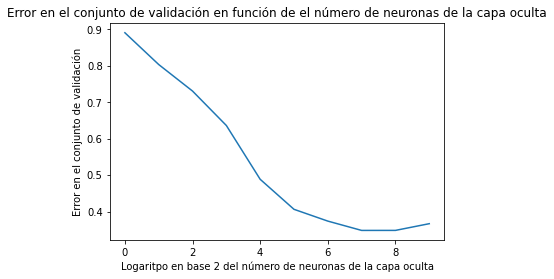

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(validation_values)
plt.xlabel('Logaritmo en base 2 del número de neuronas de la capa oculta')
plt.ylabel('Error en el conjunto de validación')
plt.title('Error en el conjunto de validación en función de el número de neuronas de la capa oculta')
plt.show()

Como se tiene que el menor errror se consigue con $2^7$ se tiene que este es el número óptimo de neuronas. 

##### Probando el número de concatenaciones de LSTMS

In [ ]:
# Creamos nuestro modelo.
validation_values = []
HIDDEN_DIM = 2**7 # dimensión de la capas LSTM
for i in range(1,11):
    
  model = NER_RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                          N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX, num_layers=i)

  baseline_model_name = 'baseline'  # nombre que tendrá el modelo guardado...

  model_name = baseline_model_name
  criterion = baseline_criterion
  n_epochs = baseline_n_epochs

  model.apply(init_weights)
  print(f'El modelo actual tiene {count_parameters(model):,} parámetros entrenables.')
  # Optimizador
  optimizer = optim.Adam(model.parameters())

  # Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
  model = model.to(device)
  criterion = criterion.to(device)


  best_valid_loss = float('inf')

  for epoch in range(n_epochs):

      start_time = time.time()

      # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

      # Entrenar
      train_loss, train_precision, train_recall, train_f1 = train(
          model, train_iterator, optimizer, criterion)

      # Evaluar (valid = validación)
      valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
          model, valid_iterator, criterion)

      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
      # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), '{}.pt'.format(model_name))
      # Si ya no mejoramos el loss de validación, terminamos de entrenar.

      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(
          f'\tTrain Loss: {train_loss:.3f} | Train f1: {train_f1:.2f} | Train precision: {train_precision:.2f} | Train recall: {train_recall:.2f}'
      )
      print(
          f'\t Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} |  Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
      )
  # cargar el mejor modelo entrenado.
  model.load_state_dict(torch.load('{}.pt'.format(model_name)))

  # Limpiar ram de cuda
  torch.cuda.empty_cache()

  valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
      model, valid_iterator, criterion)

  validation_values += [valid_loss]

  print(
      f'Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} | Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
  )

El modelo actual tiene 5,297,360 parámetros entrenables.
to device cuda!!!!


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 1.400 | Train f1: 0.01 | Train precision: 0.05 | Train recall: 0.01
	 Val. Loss: 1.065 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 1.042 | Train f1: 0.05 | Train precision: 0.21 | Train recall: 0.03
	 Val. Loss: 0.866 |  Val. f1: 0.08 |  Val. precision: 0.35 | Val. recall: 0.05
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.886 | Train f1: 0.26 | Train precision: 0.40 | Train recall: 0.19
	 Val. Loss: 0.778 |  Val. f1: 0.33 |  Val. precision: 0.42 | Val. recall: 0.27
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.795 | Train f1: 0.33 | Train precision: 0.43 | Train recall: 0.27
	 Val. Loss: 0.734 |  Val. f1: 0.38 |  Val. precision: 0.44 | Val. recall: 0.34
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.730 | Train f1: 0.38 | Train precision: 0.46 | Train recall: 0.33
	 Val. Loss: 0.698 |  Val. f1: 0.40 |  Val. precision: 0.45 | Val. recall: 0.36
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 1.432 | Train f1: 0.01 | Train precision: 0.11 | Train recall: 0.01
	 Val. Loss: 1.059 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 1.044 | Train f1: 0.05 | Train precision: 0.30 | Train recall: 0.03
	 Val. Loss: 0.875 |  Val. f1: 0.06 |  Val. precision: 0.38 | Val. recall: 0.03
Epoch: 03 | Epoch Time: 0m 12s
	Train Loss: 0.897 | Train f1: 0.25 | Train precision: 0.38 | Train recall: 0.19
	 Val. Loss: 0.809 |  Val. f1: 0.33 |  Val. precision: 0.41 | Val. recall: 0.27
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.816 | Train f1: 0.32 | Train precision: 0.41 | Train recall: 0.26
	 Val. Loss: 0.759 |  Val. f1: 0.35 |  Val. precision: 0.41 | Val. recall: 0.31
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.750 | Train f1: 0.37 | Train precision: 0.44 | Train recall: 0.32
	 Val. Loss: 0.719 |  Val. f1: 0.40 |  Val. precision: 0.45 | Val. recall: 0.36
Epoch: 06 | Epoch Time: 0m 11s
	Train Lo

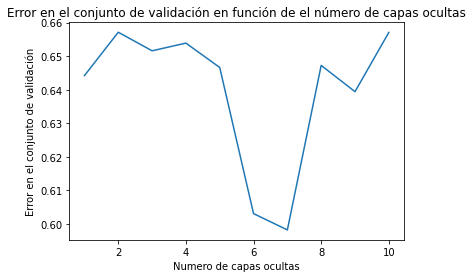

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot([i for i in range(1,11)], validation_values)
plt.xlabel('Numero de capas ocultas')
plt.ylabel('Error en el conjunto de validación')
plt.title('Error en el conjunto de validación en función de el número de capas ocultas')
plt.show()

A pesar que concatenar celdas de LSTM disminuye el error en el conjunto de validación, no se justifica en términos de tiempo de cómputo, ya que las diferencias de error son muy pequeñas. Por lo tanto, no se decide concatenar celdas. 

##### Probando el número de capas ocultas

In [ ]:
# Creamos nuestro modelo.
validation_values = []
HIDDEN_DIM = 2**7 # dimensión de la capas LSTM
for i in range(1,11):
  N_LAYERS = i
  model = NER_RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                          N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

  baseline_model_name = 'baseline'  # nombre que tendrá el modelo guardado...

  model_name = baseline_model_name
  criterion = baseline_criterion
  n_epochs = baseline_n_epochs

  model.apply(init_weights)
  print(f'El modelo actual tiene {count_parameters(model):,} parámetros entrenables.')
  # Optimizador
  optimizer = optim.Adam(model.parameters())

  # Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
  model = model.to(device)
  criterion = criterion.to(device)


  best_valid_loss = float('inf')

  for epoch in range(n_epochs):

      start_time = time.time()

      # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

      # Entrenar
      train_loss, train_precision, train_recall, train_f1 = train(
          model, train_iterator, optimizer, criterion)

      # Evaluar (valid = validación)
      valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
          model, valid_iterator, criterion)

      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
      # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), '{}.pt'.format(model_name))
      # Si ya no mejoramos el loss de validación, terminamos de entrenar.

      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(
          f'\tTrain Loss: {train_loss:.3f} | Train f1: {train_f1:.2f} | Train precision: {train_precision:.2f} | Train recall: {train_recall:.2f}'
      )
      print(
          f'\t Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} |  Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
      )
  # cargar el mejor modelo entrenado.
  model.load_state_dict(torch.load('{}.pt'.format(model_name)))

  # Limpiar ram de cuda
  torch.cuda.empty_cache()

  valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
      model, valid_iterator, criterion)

  validation_values += [valid_loss]

  print(
      f'Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} | Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
  )

El modelo actual tiene 5,294,784 parámetros entrenables.
to device cuda!!!!


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 1.320 | Train f1: 0.05 | Train precision: 0.28 | Train recall: 0.04
	 Val. Loss: 0.895 |  Val. f1: 0.10 |  Val. precision: 0.44 | Val. recall: 0.06
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.903 | Train f1: 0.27 | Train precision: 0.42 | Train recall: 0.20
	 Val. Loss: 0.702 |  Val. f1: 0.42 |  Val. precision: 0.56 | Val. recall: 0.34
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.740 | Train f1: 0.42 | Train precision: 0.52 | Train recall: 0.36
	 Val. Loss: 0.593 |  Val. f1: 0.52 |  Val. precision: 0.60 | Val. recall: 0.46
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.638 | Train f1: 0.49 | Train precision: 0.57 | Train recall: 0.44
	 Val. Loss: 0.549 |  Val. f1: 0.55 |  Val. precision: 0.61 | Val. recall: 0.50
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.575 | Train f1: 0.54 | Train precision: 0.61 | Train recall: 0.49
	 Val. Loss: 0.521 |  Val. f1: 0.56 |  Val. precision: 0.63 | Val. recall: 0.51
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.738 | Train f1: 0.37 | Train precision: 0.46 | Train recall: 0.31
	 Val. Loss: 0.670 |  Val. f1: 0.43 |  Val. precision: 0.53 | Val. recall: 0.36
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.656 | Train f1: 0.48 | Train precision: 0.57 | Train recall: 0.42
	 Val. Loss: 0.613 |  Val. f1: 0.54 |  Val. precision: 0.61 | Val. recall: 0.48
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.594 | Train f1: 0.55 | Train precision: 0.62 | Train recall: 0.50
	 Val. Loss: 0.574 |  Val. f1: 0.60 |  Val. precision: 0.67 | Val. recall: 0.55
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.549 | Train f1: 0.59 | Train precision: 0.65 | Train recall: 0.54
	 Val. Loss: 0.552 |  Val. f1: 0.63 |  Val. precision: 0.68 | Val. recall: 0.59
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.514 | Train f1: 0.62 | Train precision: 0.67 | Train recall: 0.57
	 Val. Loss: 0.540 |  Val. f1: 0.64 |  Val. precision: 0.69 | Val. recall: 0.61
Epoch: 09 | Epoch Time: 0m 7s
	Train Loss: 0.

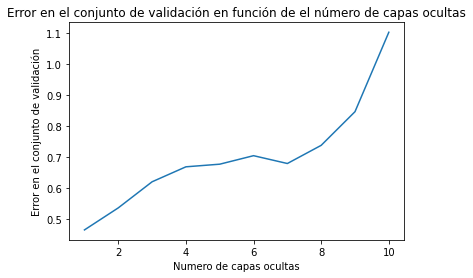

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot([i for i in range(1,11)], validation_values)
plt.xlabel('Numero de capas ocultas')
plt.ylabel('Error en el conjunto de validación')
plt.title('Error en el conjunto de validación en función de el número de capas ocultas')
plt.show()

Se concluye que al aumentar el número de capas ocultas aumenta el errror. Pero al observar la consola, se tiene que el mayor f1 score se consigue cuando se tienen 2 capas ocultas, por lo tanto se elige este valor. 

### Modelo 8: Experimentadndo con GRU

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Definir la red
class NER_RNN_GRU(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim,
                 n_layers, 
                 bidirectional, 
                 dropout, 
                 pad_idx, 
                 num_layers = 1):

        super().__init__()

        # Capa de embedding
        self.embedding = nn.Embedding(input_dim,
                                      embedding_dim,
                                      padding_idx=pad_idx,
                                      )

        # Capa GRU
        self.GRUS = nn.ModuleList()
        self.GRUS.add_module(f'lstm1', nn.GRU(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional, 
                            dropout = dropout if n_layers > 1 else 0))
        
        if num_layers > 1:
          for i in range(1, num_layers):
            self.GRUS.add_module(f'lstm_{i}', nn.LSTM(hidden_dim,
                              hidden_dim,
                              num_layers=n_layers,
                              bidirectional=bidirectional, 
                              dropout = dropout if n_layers > 1 else 0))
          

        

        # Capa de salida
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim,
                            output_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def to(self, device):
        print(f'to device {device}!!!!')
        self.embedding.to(device)
        for gru in self.GRUS:
          gru.to(device)
        self.fc.to(device)
        self.dropout.to(device)
        return self

    def forward(self, text):

        #text = [sent len, batch size]

        # Convertir lo enviado a embedding
        embedded = self.dropout(self.embedding(text))
        
        output = embedded
        for gru in self.GRUS:
          outputs, hn = gru(output)
        #embedded = [sent len, batch size, emb dim]

        # Pasar los embeddings por la rnn (LSTM)

        #output = [sent len, batch size, hid dim * n directions]
        #hidden/cell = [n layers * n directions, batch size, hid dim]

        # Predecir usando la capa de salida.
        predictions = self.fc(self.dropout(outputs))
        #predictions = [sent len, batch size, output dim]

        return predictions

In [ ]:
# Creamos nuestro modelo.
validation_values = []

for i in range(10):
  HIDDEN_DIM = 2**i  # dimensión de la capas LSTM
  model = NER_RNN_GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                          N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

  baseline_model_name = 'baseline'  # nombre que tendrá el modelo guardado...

  model_name = baseline_model_name
  criterion = baseline_criterion
  n_epochs = baseline_n_epochs

  model.apply(init_weights)
  print(f'El modelo actual tiene {count_parameters(model):,} parámetros entrenables.')
  # Optimizador
  optimizer = optim.Adam(model.parameters())

  # Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
  model = model.to(device)
  criterion = criterion.to(device)


  best_valid_loss = float('inf')

  for epoch in range(n_epochs):

      start_time = time.time()

      # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

      # Entrenar
      train_loss, train_precision, train_recall, train_f1 = train(
          model, train_iterator, optimizer, criterion)

      # Evaluar (valid = validación)
      valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
          model, valid_iterator, criterion)

      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
      # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), '{}.pt'.format(model_name))
      # Si ya no mejoramos el loss de validación, terminamos de entrenar.

      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(
          f'\tTrain Loss: {train_loss:.3f} | Train f1: {train_f1:.2f} | Train precision: {train_precision:.2f} | Train recall: {train_recall:.2f}'
      )
      print(
          f'\t Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} |  Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
      )
  # cargar el mejor modelo entrenado.
  model.load_state_dict(torch.load('{}.pt'.format(model_name)))

  # Limpiar ram de cuda
  torch.cuda.empty_cache()

  valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
      model, valid_iterator, criterion)

  validation_values += [valid_loss]

  print(
      f'Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} | Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
  )

El modelo actual tiene 5,279,214 parámetros entrenables.
to device cuda!!!!


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 2.069 | Train f1: 0.04 | Train precision: 0.03 | Train recall: 0.08
	 Val. Loss: 1.467 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 1.556 | Train f1: 0.00 | Train precision: 0.00 | Train recall: 0.00
	 Val. Loss: 1.257 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 1.436 | Train f1: 0.00 | Train precision: 0.00 | Train recall: 0.00
	 Val. Loss: 1.190 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 1.334 | Train f1: 0.00 | Train precision: 0.00 | Train recall: 0.00
	 Val. Loss: 1.132 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 1.247 | Train f1: 0.00 | Train precision: 0.01 | Train recall: 0.00
	 Val. Loss: 1.072 |  Val. f1: 0.00 |  Val. precision: 0.00 | Val. recall: 0.00
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 1.

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 1.242 | Train f1: 0.01 | Train precision: 0.20 | Train recall: 0.00
	 Val. Loss: 1.041 |  Val. f1: 0.13 |  Val. precision: 0.41 | Val. recall: 0.08
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 1.144 | Train f1: 0.07 | Train precision: 0.40 | Train recall: 0.04
	 Val. Loss: 0.964 |  Val. f1: 0.26 |  Val. precision: 0.49 | Val. recall: 0.18
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 1.072 | Train f1: 0.17 | Train precision: 0.43 | Train recall: 0.11
	 Val. Loss: 0.916 |  Val. f1: 0.33 |  Val. precision: 0.44 | Val. recall: 0.27
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 1.012 | Train f1: 0.25 | Train precision: 0.44 | Train recall: 0.18
	 Val. Loss: 0.869 |  Val. f1: 0.33 |  Val. precision: 0.41 | Val. recall: 0.28
Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 0.956 | Train f1: 0.29 | Train precision: 0.43 | Train recall: 0.22
	 Val. Loss: 0.839 |  Val. f1: 0.33 |  Val. precision: 0.40 | Val. recall: 0.29
Epoch: 08 | Epoch Time: 0m 8s
	Train Loss: 0.

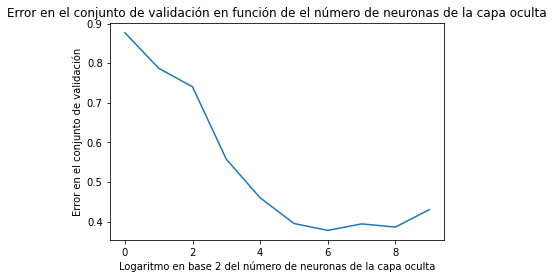

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(validation_values)
plt.xlabel('Logaritmo en base 2 del número de neuronas de la capa oculta')
plt.ylabel('Error en el conjunto de validación')
plt.title('Error en el conjunto de validación en función de el número de neuronas de la capa oculta')
plt.show()

Como se tiene que el menor error en el conjunto de validación se obtiene utilizando $2^6$, se elige este número de neuronas. 

##### Probando el número de concatenciones de capas ocultas

In [ ]:
# Creamos nuestro modelo.
validation_values = []
HIDDEN_DIM = 2**6 # dimensión de la capas LSTM
for i in range(1,12):
  print(f'Número de capas ocultas: {i}')
    
  model = NER_RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                          N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX, num_layers=i)

  baseline_model_name = 'baseline'  # nombre que tendrá el modelo guardado...

  model_name = baseline_model_name
  criterion = baseline_criterion
  n_epochs = baseline_n_epochs

  model.apply(init_weights)
  print(f'El modelo actual tiene {count_parameters(model):,} parámetros entrenables.')
  # Optimizador
  optimizer = optim.Adam(model.parameters())

  # Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
  model = model.to(device)
  criterion = criterion.to(device)


  best_valid_loss = float('inf')

  for epoch in range(n_epochs):

      start_time = time.time()

      # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

      # Entrenar
      train_loss, train_precision, train_recall, train_f1 = train(
          model, train_iterator, optimizer, criterion)

      # Evaluar (valid = validación)
      valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
          model, valid_iterator, criterion)

      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
      # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), '{}.pt'.format(model_name))
      # Si ya no mejoramos el loss de validación, terminamos de entrenar.

      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(
          f'\tTrain Loss: {train_loss:.3f} | Train f1: {train_f1:.2f} | Train precision: {train_precision:.2f} | Train recall: {train_recall:.2f}'
      )
      print(
          f'\t Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} |  Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
      )
  # cargar el mejor modelo entrenado.
  model.load_state_dict(torch.load('{}.pt'.format(model_name)))

  # Limpiar ram de cuda
  torch.cuda.empty_cache()

  valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
      model, valid_iterator, criterion)

  validation_values += [valid_loss]

  print(
      f'Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} | Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
  )

Número de capas ocultas: 1
El modelo actual tiene 5,664,896 parámetros entrenables.
to device cuda!!!!


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.955 | Train f1: 0.31 | Train precision: 0.48 | Train recall: 0.24
	 Val. Loss: 0.625 |  Val. f1: 0.56 |  Val. precision: 0.76 | Val. recall: 0.45
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.561 | Train f1: 0.61 | Train precision: 0.71 | Train recall: 0.54
	 Val. Loss: 0.462 |  Val. f1: 0.66 |  Val. precision: 0.74 | Val. recall: 0.61
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.412 | Train f1: 0.71 | Train precision: 0.76 | Train recall: 0.67
	 Val. Loss: 0.406 |  Val. f1: 0.72 |  Val. precision: 0.77 | Val. recall: 0.68
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.324 | Train f1: 0.78 | Train precision: 0.80 | Train recall: 0.76
	 Val. Loss: 0.387 |  Val. f1: 0.74 |  Val. precision: 0.77 | Val. recall: 0.71
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.266 | Train f1: 0.81 | Train precision: 0.82 | Train recall: 0.81
	 Val. Loss: 0.385 |  Val. f1: 0.75 |  Val. precision: 0.76 | Val. recall: 0.74
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss:

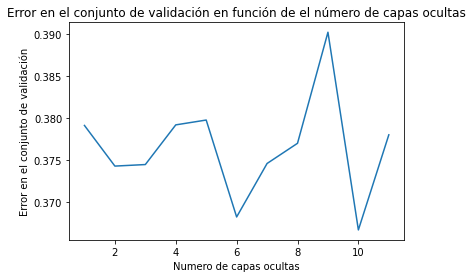

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot([i for i in range(1,12)], validation_values)
plt.xlabel('Numero de capas ocultas')
plt.ylabel('Error en el conjunto de validación')
plt.title('Error en el conjunto de validación en función de el número de capas ocultas')
plt.show()

Al igual que cuando se realizó este experimento con las celdas LSTM, se elige no concatenar celdas GRU, porque no mejora signifiquitivamente el error. 

##### Probando el número de capas ocultas

In [ ]:
# Creamos nuestro modelo.
validation_values = []
HIDDEN_DIM = 2**6 #
for i in range(1,12):
  print(f'Número de capas ocultas: {i}')
  N_LAYERS = i
  model = NER_RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                          N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

  baseline_model_name = 'baseline'  # nombre que tendrá el modelo guardado...

  model_name = baseline_model_name
  criterion = baseline_criterion
  n_epochs = baseline_n_epochs

  model.apply(init_weights)
  print(f'El modelo actual tiene {count_parameters(model):,} parámetros entrenables.')
  # Optimizador
  optimizer = optim.Adam(model.parameters())

  # Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
  model = model.to(device)
  criterion = criterion.to(device)


  best_valid_loss = float('inf')

  for epoch in range(n_epochs):

      start_time = time.time()

      # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

      # Entrenar
      train_loss, train_precision, train_recall, train_f1 = train(
          model, train_iterator, optimizer, criterion)

      # Evaluar (valid = validación)
      valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
          model, valid_iterator, criterion)

      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
      # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), '{}.pt'.format(model_name))
      # Si ya no mejoramos el loss de validación, terminamos de entrenar.

      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(
          f'\tTrain Loss: {train_loss:.3f} | Train f1: {train_f1:.2f} | Train precision: {train_precision:.2f} | Train recall: {train_recall:.2f}'
      )
      print(
          f'\t Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} |  Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
      )
  # cargar el mejor modelo entrenado.
  model.load_state_dict(torch.load('{}.pt'.format(model_name)))

  # Limpiar ram de cuda
  torch.cuda.empty_cache()

  valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
      model, valid_iterator, criterion)

  validation_values += [valid_loss]

  print(
      f'Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} | Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
  )

Número de capas ocultas: 1
El modelo actual tiene 5,466,240 parámetros entrenables.
to device cuda!!!!


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.890 | Train f1: 0.35 | Train precision: 0.55 | Train recall: 0.29
	 Val. Loss: 0.524 |  Val. f1: 0.60 |  Val. precision: 0.73 | Val. recall: 0.52
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.472 | Train f1: 0.67 | Train precision: 0.74 | Train recall: 0.62
	 Val. Loss: 0.401 |  Val. f1: 0.70 |  Val. precision: 0.77 | Val. recall: 0.65
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.342 | Train f1: 0.76 | Train precision: 0.80 | Train recall: 0.73
	 Val. Loss: 0.363 |  Val. f1: 0.74 |  Val. precision: 0.79 | Val. recall: 0.71
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.274 | Train f1: 0.80 | Train precision: 0.83 | Train recall: 0.79
	 Val. Loss: 0.358 |  Val. f1: 0.75 |  Val. precision: 0.79 | Val. recall: 0.73
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.222 | Train f1: 0.84 | Train precision: 0.86 | Train recall: 0.83
	 Val. Loss: 0.362 |  Val. f1: 0.76 |  Val. precision: 0.80 | Val. recall: 0.73
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.900 | Train f1: 0.36 | Train precision: 0.54 | Train recall: 0.29
	 Val. Loss: 0.543 |  Val. f1: 0.60 |  Val. precision: 0.74 | Val. recall: 0.51
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.507 | Train f1: 0.65 | Train precision: 0.73 | Train recall: 0.59
	 Val. Loss: 0.417 |  Val. f1: 0.69 |  Val. precision: 0.74 | Val. recall: 0.65
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.368 | Train f1: 0.74 | Train precision: 0.78 | Train recall: 0.71
	 Val. Loss: 0.380 |  Val. f1: 0.74 |  Val. precision: 0.78 | Val. recall: 0.70
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.285 | Train f1: 0.80 | Train precision: 0.82 | Train recall: 0.78
	 Val. Loss: 0.378 |  Val. f1: 0.75 |  Val. precision: 0.77 | Val. recall: 0.73
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.241 | Train f1: 0.83 | Train precision: 0.84 | Train recall: 0.82
	 Val. Loss: 0.374 |  Val. f1: 0.76 |  Val. precision: 0.76 | Val. recall: 0.75
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.

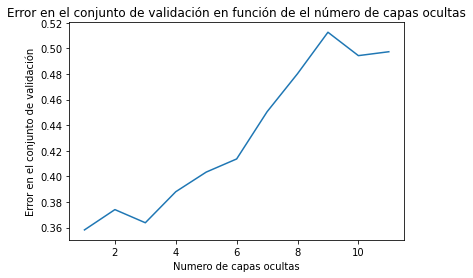

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot([i for i in range(1,12)], validation_values)
plt.xlabel('Numero de capas ocultas')
plt.ylabel('Error en el conjunto de validación')
plt.title('Error en el conjunto de validación en función de el número de capas ocultas')
plt.show()

Como se tiene el mejor f1 score utilizando 2 capas ocultas y no se tiene un error significativamente alto, se escoge este número de capas ocultas.

### Modelo 9: Encoder-Decoder con Attention

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell


class Decoder(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(hidden_size * 2 + embedding_size, hidden_size, num_layers)

        self.energy = nn.Linear(hidden_size * 3, 1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, x, encoder_states, hidden, cell):
        x = x.unsqueeze(0)
        # x: (1, N) where N is the batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_states), dim=2)))
        # energy: (seq_length, N, 1)

        attention = self.softmax(energy)
        # attention: (seq_length, N, 1)

        # attention: (seq_length, N, 1), snk
        # encoder_states: (seq_length, N, hidden_size*2), snl
        # we want context_vector: (1, N, hidden_size*2), i.e knl
        context_vector = torch.einsum("snk,snl->knl", attention, encoder_states)
        #print(context_vector.size(), embedding.size())
        rnn_input = torch.cat((context_vector, embedding), dim=2)
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target=None, teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0] if target!=None else source.shape[0]
        target_vocab_size = len(NER_TAGS.vocab)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        # First input will be <SOS> token
        x = torch.zeros(batch_size, dtype=torch.int64).to(device)
        for t in range(1, target_len):
            # At every time step use encoder_states and update hidden, cell
            output, hidden, cell = self.decoder(x, encoder_states, hidden, cell)

            # Store prediction for current time step
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            if target != None:
              x = target[t] if random.random() < teacher_force_ratio else best_guess
            else:
              x = best_guess

        return outputs


def train_seq_2_seq(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_precision = 0
    epoch_recall = 0
    epoch_f1 = 0

    model.train()

    # Por cada batch del iterador de la época:
    for batch in iterator:

        # Extraemos el texto y los tags del batch que estamos procesado
        text = batch.text
        tags = batch.nertags

        # Reiniciamos los gradientes calculados en la iteración anterior
        optimizer.zero_grad()

        #text = [sent len, batch size]

        # Predecimos los tags del texto del batch.
        predictions = model(text, tags)

        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]

        # Reordenamos los datos para calcular la loss
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)

        #predictions = [sent len * batch size, output dim]



        # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
        loss = criterion(predictions, tags)
        
        # Calculamos el accuracy
        precision, recall, f1 = calculate_metrics(predictions, tags)

        # Calculamos los gradientes
        loss.backward()

        # Actualizamos los parámetros de la red
        optimizer.step()

        # Actualizamos el loss y las métricas
        epoch_loss += loss.item()
        epoch_precision += precision
        epoch_recall += recall
        epoch_f1 += f1

    return epoch_loss / len(iterator), epoch_precision / len(
        iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

In [ ]:
# tamaño del vocabulario. recuerden que la entrada son vectores bag of word(one-hot).
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300  # dimensión de los embeddings.
OUTPUT_DIM = len(NER_TAGS.vocab)  # número de clases
HIDDEN_DIM = 2**6 # dimensión de la capas LSTM

N_LAYERS = 3  # número de capas.
DROPOUT = 0.6
BIDIRECTIONAL = True


# Model hyperparameters
input_size_encoder = INPUT_DIM
input_size_decoder = INPUT_DIM
output_size = OUTPUT_DIM
encoder_embedding_size = 300
decoder_embedding_size = 300
hidden_size = 128
num_layers = 1
enc_dropout = 0.0
dec_dropout = 0.0


encoder_net = Encoder(
    input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [ ]:
model_name = 'attention'
criterion = baseline_criterion
n_epochs = baseline_n_epochs

train_error = []
val_error = []

print(f'El modelo actual tiene {count_parameters(model):,} parámetros entrenables.')
# Optimizador
optimizer = optim.Adam(model.parameters())

# Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
model = model.to(device)
criterion = criterion.to(device)


best_valid_loss = float('inf')

for epoch in range(n_epochs):

    start_time = time.time()

    # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

    # Entrenar
    train_loss, train_precision, train_recall, train_f1 = train_seq_2_seq(
        model, train_iterator, optimizer, criterion)

    # Evaluar (valid = validación)
    valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
        model, valid_iterator, criterion)
    
    train_error += [train_loss]
    val_error += [valid_loss]

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
    # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '{}.pt'.format(model_name))
    # Si ya no mejoramos el loss de validación, terminamos de entrenar.

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(
        f'\tTrain Loss: {train_loss:.3f} | Train f1: {train_f1:.2f} | Train precision: {train_precision:.2f} | Train recall: {train_recall:.2f}'
    )
    print(
        f'\t Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} |  Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
    )
# cargar el mejor modelo entrenado.
model.load_state_dict(torch.load('{}.pt'.format(model_name)))

# Limpiar ram de cuda
torch.cuda.empty_cache()

valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
    model, valid_iterator, criterion)


print(
    f'Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} | Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
)



El modelo actual tiene 11,413,877 parámetros entrenables.


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Epoch: 01 | Epoch Time: 0m 49s
	Train Loss: 0.596 | Train f1: 0.62 | Train precision: 0.76 | Train recall: 0.53
	 Val. Loss: 0.905 |  Val. f1: 0.40 |  Val. precision: 0.66 | Val. recall: 0.30
Epoch: 02 | Epoch Time: 0m 48s
	Train Loss: 0.570 | Train f1: 0.64 | Train precision: 0.78 | Train recall: 0.55
	 Val. Loss: 0.900 |  Val. f1: 0.45 |  Val. precision: 0.59 | Val. recall: 0.37
Epoch: 03 | Epoch Time: 0m 43s
	Train Loss: 0.551 | Train f1: 0.66 | Train precision: 0.79 | Train recall: 0.57
	 Val. Loss: 0.898 |  Val. f1: 0.43 |  Val. precision: 0.62 | Val. recall: 0.33
Epoch: 04 | Epoch Time: 0m 43s
	Train Loss: 0.538 | Train f1: 0.67 | Train precision: 0.79 | Train recall: 0.58
	 Val. Loss: 0.907 |  Val. f1: 0.44 |  Val. precision: 0.64 | Val. recall: 0.34
Epoch: 05 | Epoch Time: 0m 43s
	Train Loss: 0.519 | Train f1: 0.68 | Train precision: 0.80 | Train recall: 0.59
	 Val. Loss: 0.919 |  Val. f1: 0.45 |  Val. precision: 0.60 | Val. recall: 0.37
Epoch: 06 | Epoch Time: 0m 43s
	Train Lo

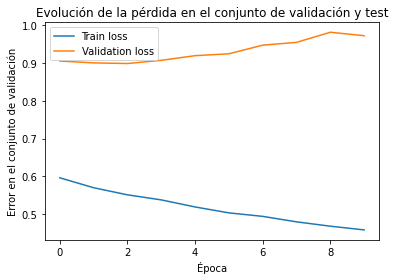

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_error, label='Train loss')
ax.plot(val_error, label = 'Validation loss')
plt.xlabel('Época')
plt.ylabel('Error en el conjunto de validación')
plt.title('Evolución de la pérdida en el conjunto de validación y test')
plt.legend()
plt.show()

En este caso, a pesar de que el modelo puede realizar predicciones, el error en el conjunto de validación no parece disminuir. Esto se puede deber a que pudo haber sucedido un error de implementación o no se entrenó por el suficiente número de épocas. Por lo tanto, no se escoge este modelo para seguir experimentando.

---------------


### Modelo FINAL

Este modelo final se contruye en base a los resultados de los experimentos anteriores y consta en lo siguiente


*   Capa GRU (Envez de LSTM)
*   Bidireccionalidad
*   Embeddings pre-entrenados de zenodo
*   4 Epocas de entrenamiento
*   HIDDEN DIM igual a 64
*   Numero de capas ocultas igual a 2



In [ ]:
!wget https://zenodo.org/record/3924799/files/cwlce.vec -nc

# Primer Field: TEXT. Representan los tokens de la secuencia
# Esta vez se convierten a minusculas los caracteres
# esto para facilitar la correspondencia de palabras al vector de embedding
# independiente del uso de mayusculas.
TEXT2 = legacy.data.Field(lower=True) 

# Segundo Field: NER_TAGS. Representan los Tags asociados a cada palabra.
NER_TAGS2 = legacy.data.Field(unk_token=None)
fields2 = (("text", TEXT2), ("nertags", NER_TAGS2))

train_data, valid_data, test_data = legacy.datasets.SequenceTaggingDataset.splits(
    path="./",
    train="train.txt",
    validation="dev.txt",
    test="test.txt",
    fields=fields2,
    encoding="utf-8",
    separator=" "
)

TEXT2.build_vocab(train_data)
NER_TAGS2.build_vocab(train_data)

print(f"Tokens únicos en TEXT: {len(TEXT2.vocab)}")
print(f"Tokens únicos en NER_TAGS: {len(TEXT.vocab)}")

!pip install unidecode

import unidecode
from torchtext import vocab
#Se remueven los acentos de los tokens del vocabulario
TEXT2.vocab.itos = [unidecode.unidecode(x) for x in TEXT2.vocab.itos]

popi = vocab.Vectors('cwlce.vec') #vectores entrenados en diagnosticos de lista de espera.
taba = popi.get_vecs_by_tokens(TEXT2.vocab.itos) #se hace un match entre las palabras del vocabulario que estén presentes en los embeddings

File ‘cwlce.vec’ already there; not retrieving.

Tokens únicos en TEXT: 12772
Tokens únicos en NER_TAGS: 17591
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# tamaño del vocabulario. recuerden que la entrada son vectores bag of word(one-hot).
INPUT_DIM = len(TEXT2.vocab)
EMBEDDING_DIM = popi.dim  # dimensión de los embeddings.
HIDDEN_DIM = 64 # dimensión de la capas GRU
OUTPUT_DIM = len(NER_TAGS2.vocab)  # número de clases

N_LAYERS = 2  # número de capas.
DROPOUT = 0.5
BIDIRECTIONAL = True

model_final = NER_RNN_GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                         N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
model_name_final = 'FINAL_MODEL'
n_epochs_final = 5
# loss_3 = ...

#### Experimento final

In [ ]:
model = model_final
model_name = model_name_final
criterion = baseline_criterion
n_epochs = n_epochs_final

In [ ]:
# Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
#exp_baseline_model = copy.deepcopy(baseline_model)
#exp_emb_model = copy.deepcopy(emb_model)

models = [[baseline_model, baseline_model_name], [model_final, model_final]]
results = []

for a_model in models:

    model = a_model[0]
    model_name = a_model[1]
    criterion = baseline_criterion
    n_epochs = baseline_n_epochs

    def init_weights(m):
        # Inicializamos los pesos como aleatorios
        if model_name == 'embeddingsClinicos':
          model.embedding.from_pretrained(taba, False) 
        else: 
          for name, param in m.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1) 
            
        # Seteamos como 0 los embeddings de UNK y PAD.
        model.embedding.weight.data[UNK_IDX] = torch.zeros(model.embedding.embedding_dim)
        model.embedding.weight.data[PAD_IDX] = torch.zeros(model.embedding.embedding_dim)
            
    model.apply(init_weights)

    

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Optimizador
    optimizer = optim.Adam(model.parameters())

    # Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
    model = model.to(device)
    criterion = criterion.to(device)

    def train(model, iterator, optimizer, criterion):

        epoch_loss = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0

        model.train()

        # Por cada batch del iterador de la época:
        for batch in iterator:

            # Extraemos el texto y los tags del batch que estamos procesado
            text = batch.text
            tags = batch.nertags

            # Reiniciamos los gradientes calculados en la iteración anterior
            optimizer.zero_grad()

            #text = [sent len, batch size]

            # Predecimos los tags del texto del batch.
            predictions = model(text)

            #predictions = [sent len, batch size, output dim]
            #tags = [sent len, batch size]

            # Reordenamos los datos para calcular la loss
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            #predictions = [sent len * batch size, output dim]



            # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
            loss = criterion(predictions, tags)
            
            # Calculamos el accuracy
            precision, recall, f1 = calculate_metrics(predictions, tags)

            # Calculamos los gradientes
            loss.backward()

            # Actualizamos los parámetros de la red
            optimizer.step()

            # Actualizamos el loss y las métricas
            epoch_loss += loss.item()
            epoch_precision += precision
            epoch_recall += recall
            epoch_f1 += f1

        return epoch_loss / len(iterator), epoch_precision / len(
            iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

    def evaluate(model, iterator, criterion):

        epoch_loss = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0

        model.eval()

        # Indicamos que ahora no guardaremos los gradientes
        with torch.no_grad():
            # Por cada batch
            for batch in iterator:

                text = batch.text
                tags = batch.nertags

                # Predecimos
                predictions = model(text)

                predictions = predictions.view(-1, predictions.shape[-1])
                tags = tags.view(-1)

                # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
                loss = criterion(predictions, tags)

                # Calculamos las métricas
                precision, recall, f1 = calculate_metrics(predictions, tags)

                # Actualizamos el loss y las métricas
                epoch_loss += loss.item()
                epoch_precision += precision
                epoch_recall += recall
                epoch_f1 += f1

        return epoch_loss / len(iterator), epoch_precision / len(
            iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

    import time

    def epoch_time(start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    best_valid_loss = float('inf')
    best_loss_f1 = -1
    best_loss_epoch = -1

    for epoch in range(n_epochs):

        start_time = time.time()

        # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

        # Entrenar
        train_loss, train_precision, train_recall, train_f1 = train(
            model, train_iterator, optimizer, criterion)

        # Evaluar (valid = validación)
        valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
            model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
        # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_loss_f1 = valid_f1
            best_loss_epoch = epoch
            torch.save(model.state_dict(), '{}.pt'.format(model_name))
        # Si ya no mejoramos el loss de validación, terminamos de entrenar.

    results.append({'model': model_name, 'epoch': best_loss_epoch,'loss': best_valid_loss, 'f1': best_loss_f1})

print(results)

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[{'model': 'baseline', 'epoch': 5, 'loss': 0.4105681822236095, 'f1': 0.7285739721227531}, {'model': NER_RNN_GRU(
  (embedding): Embedding(17591, 200, padding_idx=1)
  (gru): GRU(200, 64, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=128, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
), 'epoch': 2, 'loss': 0.3576923133805394, 'f1': 0.7477914183359858}]


------
### **Entrenamos y evaluamos**


**Importante** : Fijen el modelo, el número de épocas de entrenamiento, la loss y el optimizador que usarán para entrenar y evaluar en las siguientes variables!!!



#### **Inicializamos la red**

Iniciamos los pesos de la red de forma aleatoria (Usando una distribución normal).


In [ ]:
model = baseline_model
model_name = baseline_model_name
criterion = baseline_criterion
n_epochs = baseline_n_epochs

In [ ]:
def init_weights(m):
    # Inicializamos los pesos como aleatorios
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.1) 
        
    # Seteamos como 0 los embeddings de UNK y PAD.
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
        
model.apply(init_weights)

NER_RNN(
  (embedding): Embedding(17591, 200, padding_idx=1)
  (lstm): LSTM(200, 128, num_layers=3, dropout=0.5)
  (fc): Linear(in_features=128, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# Optimizador
optimizer = optim.Adam(model.parameters())

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'El modelo actual tiene {count_parameters(model):,} parámetros entrenables.')

El modelo actual tiene 3,844,612 parámetros entrenables.


Notar que definimos los embeddings que representan a \<unk\> y \<pad\>  como [0, 0, ..., 0]

#### **Definimos el optimizador**

In [ ]:
# Optimizador
optimizer = optim.Adam(model.parameters())

#### **Enviamos el modelo a cuda**


In [ ]:
# Enviamos el modelo y la loss a cuda (en el caso en que esté disponible)
model = model.to(device)
criterion = criterion.to(device)

#### **Definimos el entrenamiento de la red**

Algunos conceptos previos: 

- `epoch` : una pasada de entrenamiento completa de una dataset.
- `batch`: una fracción de la época. Se utilizan para entrenar mas rápidamente la red. (mas eficiente pasar n datos que uno en cada ejecución del backpropagation)

Esta función está encargada de entrenar la red en una época. Para esto, por cada batch de la época actual, predice los tags del texto, calcula su loss y luego hace backpropagation para actualizar los pesos de la red.

Observación: En algunos comentarios aparecerá el tamaño de los tensores entre corchetes

In [ ]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_precision = 0
    epoch_recall = 0
    epoch_f1 = 0

    model.train()

    # Por cada batch del iterador de la época:
    for batch in iterator:

        # Extraemos el texto y los tags del batch que estamos procesado
        text = batch.text
        tags = batch.nertags

        # Reiniciamos los gradientes calculados en la iteración anterior
        optimizer.zero_grad()

        #text = [sent len, batch size]

        # Predecimos los tags del texto del batch.
        predictions = model(text)

        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]

        # Reordenamos los datos para calcular la loss
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)

        #predictions = [sent len * batch size, output dim]



        # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
        loss = criterion(predictions, tags)
        
        # Calculamos el accuracy
        precision, recall, f1 = calculate_metrics(predictions, tags)

        # Calculamos los gradientes
        loss.backward()

        # Actualizamos los parámetros de la red
        optimizer.step()

        # Actualizamos el loss y las métricas
        epoch_loss += loss.item()
        epoch_precision += precision
        epoch_recall += recall
        epoch_f1 += f1

    return epoch_loss / len(iterator), epoch_precision / len(
        iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

#### **Definimos la función de evaluación**

Evalua el rendimiento actual de la red usando los datos de validación. 

Por cada batch de estos datos, calcula y reporta el loss y las métricas asociadas al conjunto de validación. 
Ya que las métricas son calculadas por cada batch, estas son retornadas promediadas por el número de batches entregados. (ver linea del return)

In [ ]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_precision = 0
    epoch_recall = 0
    epoch_f1 = 0

    model.eval()

    # Indicamos que ahora no guardaremos los gradientes
    with torch.no_grad():
        # Por cada batch
        for batch in iterator:

            text = batch.text
            tags = batch.nertags

            # Predecimos
            predictions = model(text)

            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
            loss = criterion(predictions, tags)

            # Calculamos las métricas
            precision, recall, f1 = calculate_metrics(predictions, tags)

            # Actualizamos el loss y las métricas
            epoch_loss += loss.item()
            epoch_precision += precision
            epoch_recall += recall
            epoch_f1 += f1

    return epoch_loss / len(iterator), epoch_precision / len(
        iterator), epoch_recall / len(iterator), epoch_f1 / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


#### **Entrenamiento de la red**

En este cuadro de código ejecutaremos el entrenamiento de la red.
Para esto, primero definiremos el número de épocas y luego por cada época, ejecutaremos `train` y `evaluate`.

**Importante: Reiniciar los pesos del modelo**

Si ejecutas nuevamente esta celda, se seguira entrenando el mismo modelo una y otra vez. 
Para reiniciar el modelo se debe ejecutar nuevamente la celda que contiene la función `init_weights`



In [ ]:
best_valid_loss = float('inf')

for epoch in range(n_epochs):

    start_time = time.time()

    # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

    # Entrenar
    train_loss, train_precision, train_recall, train_f1 = train(
        model, train_iterator, optimizer, criterion)

    # Evaluar (valid = validación)
    valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
        model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
    # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '{}.pt'.format(model_name))
    # Si ya no mejoramos el loss de validación, terminamos de entrenar.

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(
        f'\tTrain Loss: {train_loss:.3f} | Train f1: {train_f1:.2f} | Train precision: {train_precision:.2f} | Train recall: {train_recall:.2f}'
    )
    print(
        f'\t Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} |  Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
    )

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <pad> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.872 | Train f1: 0.37 | Train precision: 0.52 | Train recall: 0.30
	 Val. Loss: 0.551 |  Val. f1: 0.59 |  Val. precision: 0.72 | Val. recall: 0.50
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.506 | Train f1: 0.64 | Train precision: 0.70 | Train recall: 0.60
	 Val. Loss: 0.429 |  Val. f1: 0.69 |  Val. precision: 0.74 | Val. recall: 0.65
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.380 | Train f1: 0.73 | Train precision: 0.76 | Train recall: 0.71
	 Val. Loss: 0.413 |  Val. f1: 0.71 |  Val. precision: 0.73 | Val. recall: 0.69
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.307 | Train f1: 0.78 | Train precision: 0.80 | Train recall: 0.77
	 Val. Loss: 0.427 |  Val. f1: 0.72 |  Val. precision: 0.75 | Val. recall: 0.71
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.261 | Train f1: 0.82 | Train precision: 0.82 | Train recall: 0.81
	 Val. Loss: 0.422 |  Val. f1: 0.74 |  Val. precision: 0.75 | Val. recall: 0.72
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.

**Importante**: Recuerden que el último modelo entrenado no es el mejor (probablemente esté *overfitteado*), si no el que guardamos con la menor loss del conjunto de validación. Este problema lo pueden solucionar con *early stopping*.
Para cargar el mejor modelo entrenado, ejecuten la siguiente celda.



In [ ]:
# cargar el mejor modelo entrenado.
model.load_state_dict(torch.load('{}.pt'.format(model_name)))

In [ ]:
# Limpiar ram de cuda
torch.cuda.empty_cache()

#### **Evaluamos el set de validación con el modelo final**

Estos son los resultados de predecir el dataset de evaluación con el *mejor* modelo entrenado.

In [ ]:
valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
    model, valid_iterator, criterion)

print(
    f'Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} | Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
)

### **Predecir datos para la competencia**

Ahora, a partir de los datos de **test** y nuestro modelo entrenado, vamos a predecir las etiquetas que serán evaluadas en la competencia.

In [ ]:
def predict_labels(model, iterator, criterion, fields=fields):

    # Extraemos los vocabularios.
    text_field = fields[0][1]
    nertags_field = fields[1][1]
    tags_vocab = nertags_field.vocab.itos
    words_vocab = text_field.vocab.itos

    model.eval()

    predictions = []

    with torch.no_grad():

        for batch in iterator:

            text_batch = batch.text
            text_batch = torch.transpose(text_batch, 0, 1).tolist()

            # Predecir los tags de las sentences del batch
            predictions_batch = model(batch.text)
            predictions_batch = torch.transpose(predictions_batch, 0, 1)

            # por cada oración predicha:
            for sentence, sentence_prediction in zip(text_batch,
                                                     predictions_batch):
                for word_idx, word_predictions in zip(sentence,
                                                      sentence_prediction):
                    # Obtener el indice del tag con la probabilidad mas alta.
                    argmax_index = word_predictions.topk(1)[1]

                    current_tag = tags_vocab[argmax_index]
                    # Obtenemos la palabra
                    current_word = words_vocab[word_idx]

                    if current_word != '<pad>':
                        predictions.append([current_word, current_tag])
                predictions.append(['EOS', 'EOS'])


    return predictions


predictions = predict_labels(model, test_iterator, criterion)

### **Generar el archivo para la submission**

No hay problema si aparecen unk en la salida. Estos no son relevantes para evaluarlos, usamos solo los tags.

In [ ]:
import os, shutil

if (os.path.isfile('./predictions.zip')):
    os.remove('./predictions.zip')

if (not os.path.isdir('./predictions')):
    os.mkdir('./predictions')

else:
    # Eliminar predicciones anteriores:
    shutil.rmtree('./predictions')
    os.mkdir('./predictions')

f = open('predictions/predictions.txt', 'w')
for i, (word, tag) in enumerate(predictions[:-1]):
    if word=='EOS' and tag=='EOS': f.write('\n')
    else: 
      if i == len(predictions[:-1])-1:
        f.write(word + ' ' + tag)
      else: f.write(word + ' ' + tag + '\n')

f.close()

a = shutil.make_archive('predictions', 'zip', './predictions')

## **Conclusiones**



Se logró superar el baseline entregado experimentando con distintas implementaciones de RNN y variando distintos hiperparametros de la red.

Se ha logrado experimentar con distintos hiperparámetros, entre los cuales se destacan, learning rate, número de neuronas en la capa oculta, número de capas ocultas, dropout, tipos de optimizadores, tipo de celdas (LSTM y GRU). Además, se implementó un modelo de Encoder-Decoder con mecanismo de antención, sin embargo, este realizaba un proceso de aprendizaje apropiado. Esto se puede deber a que pudo haber un error de implementación, o porque no se utilizaron hiperparámetros adecuados, que modifiquen la arquitectura del modelo o incluso el número de épocas. 

Un contratiempo fue no poder aleatorizar los vectores no encontrados en el embedding pre-entrenado. Los no encontrados quedaron nulos. 

Un problema importante fue no poder compatibilizar todas las mejoras individuales al baseline. Al momento de guardar un modelo con las mejores predicciones, se decidió intentar por un lado con los embeddings y por otro todas las modificaciones a los hiperparámetros y el cambio de LSTM por GRU. Es muy probable que el uso conjunto de todo lo mencionado entregue resultados aun mejores, quedará pendiente para futuras implementaciones.

Finalmente se cree que la tarea abordada podria ser de gran utilidad campo medico a futuro pues permitiria facilitar la asignacion de pacientes en lista de espera a especialistas idoneos para su caso particular.